# VarnaAir - Open Programme

## Introduction ℹ️
VarnaAir is a machine learning project focused on predicting the Air Quality Index (AQI) for Varna, Bulgaria. Using environmental data from two Air Monitoring Stations (Chaika and Angel Kanchev), the project applies regression models to forecast AQI levels.

I chose Varna for this project because it is my hometown and I deeply care about the environmental impact of air pollution. As a coastal city, Varna faces significant pollution from its seaport, as well as from the airport and increasing traffic levels. More importantly, it is where my family and friends live, so their health and well-being are a strong personal motivation behind this project.


## Libraries 📚
First, let's begin by importing the libraries and checking their versions.

In [2441]:
import numpy
import pandas
import seaborn
import requests

import matplotlib.pyplot as plt

from sklearn.svm import SVR
# from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

print("Library versions:")
print("- pandas:", pandas.__version__)          # 2.2.3
print("- seaborn:", seaborn.__version__)        # 0.13.2

Library versions:
- pandas: 2.2.3
- seaborn: 0.13.2


## Data provisioning 📦

Next, we will use an API key provided by OpenAQ [https://openaq.org/] to check the what Air Monitoring Stations are available in Varna, Bulgaria.

In [2379]:
url = "https://api.openaq.org/v3/locations"
headers = {
    "X-API-Key": "c1061fd64a9bd88562b4bb823b7900ccdfd263a9a7aa54614de834dac611a4ca"
}
params = {
    "coordinates": "43.224389,27.915733",  # center of Varna
    "radius": 5000                         # 5 km radius
}

response = requests.get(url, headers=headers, params=params)

data = response.json().get("results", [])
df_nearby_stations = pandas.DataFrame(data)

print(df_nearby_stations[["id", "name", "locality"]])

        id                         name              locality
0     8843  AMS SOU Angel Kanchev-Varna                 Варна
1  2162113           AMS Chaika - Varna  National air network


Now that the IDs of each location are displayed, I can access each station's sensors to obtain the measurements.

### Angel Kanchev-Varna (part 1)

In [2380]:
url = "https://api.openaq.org/v3/locations/8843/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest1 = pandas.DataFrame(results)

df_latest1

,id,name,parameter,datetimeFirst,datetimeLast,coverage,latest,summary
0,25777,o3 µg/m³,"{'id': 3, 'name': 'o3', 'units': 'µg/m³', 'dis...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
1,25778,no2 µg/m³,"{'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
2,25776,pm10 µg/m³,"{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
3,25779,co µg/m³,"{'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1000.0, 'q02': None, 'q25': None, 'me..."
4,25774,so2 µg/m³,"{'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
5,25775,pm25 µg/m³,"{'id': 2, 'name': 'pm25', 'units': 'µg/m³', 'd...","{'utc': '2020-04-20T18:00:00Z', 'local': '2020...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
6,4272879,no µg/m³,"{'id': 19843, 'name': 'no', 'units': 'µg/m³', ...","{'utc': '2023-03-29T18:00:00Z', 'local': '2023...","{'utc': '2024-03-11T11:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-03-11T11:00:00Z', '...","{'min': 0.14, 'q02': None, 'q25': None, 'media..."


In [2381]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Angel Kanchev
sensor_ids = [25777, 25778, 25776, 25779, 25774, 25775, 4272879]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df1 = pandas.DataFrame(results)

        df1 = df1.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df1['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df1['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df1['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df1['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df1['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df1['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df1)

df1 = pandas.concat(sensor_data_frames, ignore_index=True)
df1

,value,sensor_id,datetime_from_utc,datetime_from_local,datetime_to_utc,datetime_to_local,parameter_name,parameter_units
0,56.93,25777,2020-04-20T17:00:00Z,2020-04-20T20:00:00+03:00,2020-04-20T18:00:00Z,2020-04-20T21:00:00+03:00,o3,µg/m³
1,25.44,25777,2020-04-20T18:00:00Z,2020-04-20T21:00:00+03:00,2020-04-20T19:00:00Z,2020-04-20T22:00:00+03:00,o3,µg/m³
2,23.04,25777,2020-04-20T19:00:00Z,2020-04-20T22:00:00+03:00,2020-04-20T20:00:00Z,2020-04-20T23:00:00+03:00,o3,µg/m³
3,30.51,25777,2020-04-20T20:00:00Z,2020-04-20T23:00:00+03:00,2020-04-20T21:00:00Z,2020-04-21T00:00:00+03:00,o3,µg/m³
4,25.95,25777,2020-04-20T21:00:00Z,2020-04-21T00:00:00+03:00,2020-04-20T22:00:00Z,2020-04-21T01:00:00+03:00,o3,µg/m³
...,...,...,...,...,...,...,...,...
695,14.49,4272879,2023-04-02T16:00:00Z,2023-04-02T19:00:00+03:00,2023-04-02T17:00:00Z,2023-04-02T20:00:00+03:00,no,µg/m³
696,1.68,4272879,2023-04-02T17:00:00Z,2023-04-02T20:00:00+03:00,2023-04-02T18:00:00Z,2023-04-02T21:00:00+03:00,no,µg/m³
697,1.76,4272879,2023-04-02T18:00:00Z,2023-04-02T21:00:00+03:00,2023-04-02T19:00:00Z,2023-04-02T22:00:00+03:00,no,µg/m³
698,2.85,4272879,2023-04-02T19:00:00Z,2023-04-02T22:00:00+03:00,2023-04-02T20:00:00Z,2023-04-02T23:00:00+03:00,no,µg/m³


### AMS Chaika - Varna (part 1)
Let's do the same for this station as well.

In [2382]:
url = "https://api.openaq.org/v3/locations/2162113/sensors"

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()
results = data.get("results", [])

df_latest2 = pandas.DataFrame(results)

df_latest2

,id,name,parameter,datetimeFirst,datetimeLast,coverage,latest,summary
0,7774820,no µg/m³,"{'id': 19843, 'name': 'no', 'units': 'µg/m³', ...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2024-03-11T11:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-03-11T11:00:00Z', '...","{'min': 1.36, 'q02': None, 'q25': None, 'media..."
1,7774916,so2 µg/m³,"{'id': 6, 'name': 'so2', 'units': 'µg/m³', 'di...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
2,7775044,co µg/m³,"{'id': 4, 'name': 'co', 'units': 'µg/m³', 'dis...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1000.0, 'q02': None, 'q25': None, 'me..."
3,7775045,no2 µg/m³,"{'id': 5, 'name': 'no2', 'units': 'µg/m³', 'di...","{'utc': '2024-01-28T23:00:00Z', 'local': '2024...","{'utc': '2025-06-25T06:00:00Z', 'local': '2025...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2025-06-25T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."
4,8613114,pm10 µg/m³,"{'id': 1, 'name': 'pm10', 'units': 'µg/m³', 'd...","{'utc': '2024-03-18T07:00:00Z', 'local': '2024...","{'utc': '2024-06-06T06:00:00Z', 'local': '2024...","{'expectedCount': 1, 'expectedInterval': '01:0...","{'datetime': {'utc': '2024-06-06T06:00:00Z', '...","{'min': -1.0, 'q02': None, 'q25': None, 'media..."


In [2383]:
base_url = "https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

# sensor ids for Chaika
sensor_ids = [7774820, 7774916, 7775044, 7775045, 8613114]  

sensor_data_frames = []

for sensor_id in sensor_ids:
    url = base_url.format(sensor_id=sensor_id)
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    data = response.json()
    results = data.get("results", [])

    if results:
        df2 = pandas.DataFrame(results)

        df2 = df2.assign(
            sensor_id=sensor_id,
            datetime_from_utc=df2['period'].apply(lambda x: x['datetimeFrom']['utc'] if x else None),
            datetime_from_local=df2['period'].apply(lambda x: x['datetimeFrom']['local'] if x else None),
            datetime_to_utc=df2['period'].apply(lambda x: x['datetimeTo']['utc'] if x else None),
            datetime_to_local=df2['period'].apply(lambda x: x['datetimeTo']['local'] if x else None),
            parameter_name=df2['parameter'].apply(lambda x: x.get('name') if isinstance(x, dict) else None),
            parameter_units=df2['parameter'].apply(lambda x: x.get('units') if isinstance(x, dict) else None)
        ).drop(columns=['flagInfo', 'parameter', 'period', 'summary', 'coverage', 'coordinates'])

        sensor_data_frames.append(df2)

df2 = pandas.concat(sensor_data_frames, ignore_index=True)
df2

,value,sensor_id,datetime_from_utc,datetime_from_local,datetime_to_utc,datetime_to_local,parameter_name,parameter_units
0,1.51,7774820,2024-01-28T22:00:00Z,2024-01-29T00:00:00+02:00,2024-01-28T23:00:00Z,2024-01-29T01:00:00+02:00,no,µg/m³
1,1.65,7774820,2024-01-28T23:00:00Z,2024-01-29T01:00:00+02:00,2024-01-29T00:00:00Z,2024-01-29T02:00:00+02:00,no,µg/m³
2,1.54,7774820,2024-01-29T00:00:00Z,2024-01-29T02:00:00+02:00,2024-01-29T01:00:00Z,2024-01-29T03:00:00+02:00,no,µg/m³
3,1.62,7774820,2024-01-29T01:00:00Z,2024-01-29T03:00:00+02:00,2024-01-29T02:00:00Z,2024-01-29T04:00:00+02:00,no,µg/m³
4,1.66,7774820,2024-01-29T02:00:00Z,2024-01-29T04:00:00+02:00,2024-01-29T03:00:00Z,2024-01-29T05:00:00+02:00,no,µg/m³
...,...,...,...,...,...,...,...,...
495,-1.00,8613114,2024-03-29T19:00:00Z,2024-03-29T21:00:00+02:00,2024-03-29T20:00:00Z,2024-03-29T22:00:00+02:00,pm10,µg/m³
496,-1.00,8613114,2024-03-29T20:00:00Z,2024-03-29T22:00:00+02:00,2024-03-29T21:00:00Z,2024-03-29T23:00:00+02:00,pm10,µg/m³
497,-1.00,8613114,2024-03-29T21:00:00Z,2024-03-29T23:00:00+02:00,2024-03-29T22:00:00Z,2024-03-30T00:00:00+02:00,pm10,µg/m³
498,-1.00,8613114,2024-03-29T22:00:00Z,2024-03-30T00:00:00+02:00,2024-03-29T23:00:00Z,2024-03-30T01:00:00+02:00,pm10,µg/m³


The next step is to combine both datasets, as we have the latest measurements from both stations.

In [2384]:
combined_df = pandas.concat([df1, df2], ignore_index=True)

print("The API key dataset from the 2 stations contains: " + str(combined_df.shape))

The API key dataset from the 2 stations contains: (1200, 8)


While the current format might look decent, we have an issue with the data layout. Each row includes a value next to the parameter name, which means we do not have all pollutants listed on one row alongside the corresponding datetime. To resolve this, we will set the datetime as the index.

In [2385]:
combined_df = combined_df.pivot_table(
    index='datetime_from_local',
    columns='parameter_name',
    values='value'
).reset_index()

combined_df

parameter_name,datetime_from_local,co,no,no2,o3,pm10,pm25,so2
0,2020-04-20T20:00:00+03:00,400.0,NaN,23.33,56.93,24.27,18.38,20.16
1,2020-04-20T21:00:00+03:00,530.0,NaN,51.60,25.44,24.27,19.34,19.85
2,2020-04-20T22:00:00+03:00,560.0,NaN,44.01,23.04,23.85,18.33,20.77
3,2020-04-20T23:00:00+03:00,500.0,NaN,27.78,30.51,21.48,17.23,20.10
4,2020-04-21T00:00:00+03:00,480.0,NaN,25.94,25.95,21.46,19.66,19.95
...,...,...,...,...,...,...,...,...
397,2024-03-29T21:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
398,2024-03-29T22:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
399,2024-03-29T23:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN
400,2024-03-30T00:00:00+02:00,NaN,NaN,NaN,NaN,-1.00,NaN,NaN


It is clear that not all sensors work simultaneously. To visualize all missing data, we will represent it through a heatmap.

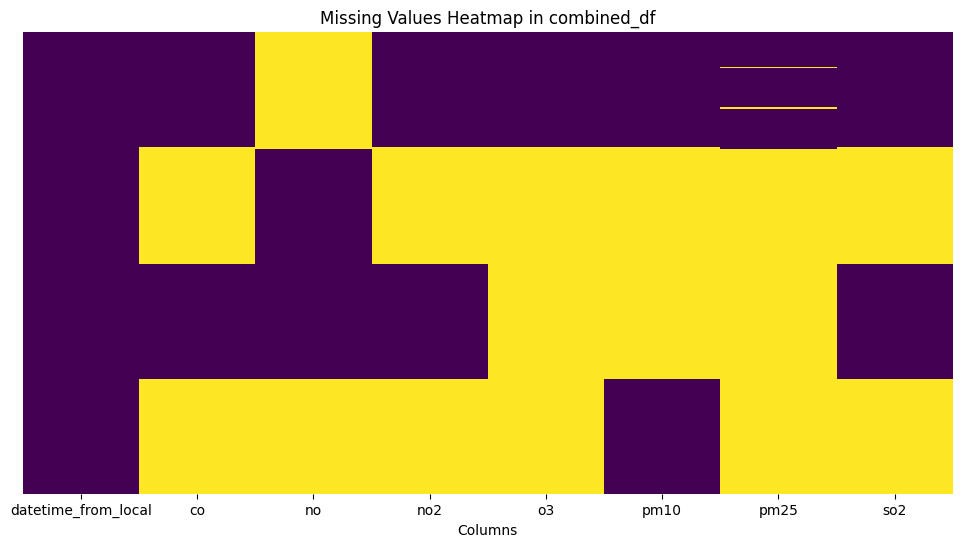

In [2386]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(combined_df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in combined_df')
plt.xlabel('Columns')
plt.show()

In [2387]:
missing_percent = combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

parameter_name
pm25                   75.124378
o3                     75.124378
co                     50.248756
no                     50.248756
pm10                   50.248756
no2                    50.248756
so2                    50.248756
datetime_from_local     0.000000
dtype: float64


Due to the significant amount of missing data for all pollutants and considering there may be alternative ways to insert data through requests that I have not yet discovered after the first week of the open programme, I decided to download the available datasets for each month from each station for the year 2025. This will ensure that the data is more recent.

### AMS Chaika - Varna (part 2)

In [2388]:
chaika1 = pandas.read_csv('datasets/openaq_location_2162113_measurments.csv')
chaika1.shape

(3000, 15)

In [2389]:
chaika2 = pandas.read_csv('datasets/openaq_location_2162113_measurments (1).csv')
chaika2.shape

(1416, 15)

In [2390]:
chaika3 = pandas.read_csv('datasets/openaq_location_2162113_measurments (2).csv')
chaika3.shape

(1857, 15)

In [2391]:
chaika4 = pandas.read_csv('datasets/openaq_location_2162113_measurments (3).csv')
chaika4.shape

(1430, 15)

In [2392]:
chaika5 = pandas.read_csv('datasets/openaq_location_2162113_measurments (4).csv')
chaika5.shape

(1354, 15)

In [2393]:
chaika_dataset = pandas.concat([chaika1, chaika2, chaika3, chaika4, chaika5])

In [2394]:
chaika_dataset.shape

(9057, 15)

In [2395]:
chaika_dataset = chaika_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

chaika_dataset

parameter,datetimeLocal,co,no2,so2
0,2025-01-01T20:00:00+02:00,1450.0,26.41,20.61
1,2025-01-02T01:00:00+02:00,1260.0,22.42,9.25
2,2025-01-02T02:00:00+02:00,1040.0,16.81,8.45
3,2025-01-02T11:00:00+02:00,940.0,22.20,11.81
4,2025-01-02T12:00:00+02:00,960.0,21.99,13.28
...,...,...,...,...
3045,2025-06-19T05:00:00+03:00,560.0,12.22,-1.00
3046,2025-06-19T06:00:00+03:00,560.0,12.20,-1.00
3047,2025-06-19T07:00:00+03:00,540.0,8.39,-1.00
3048,2025-06-19T09:00:00+03:00,540.0,11.03,-1.00


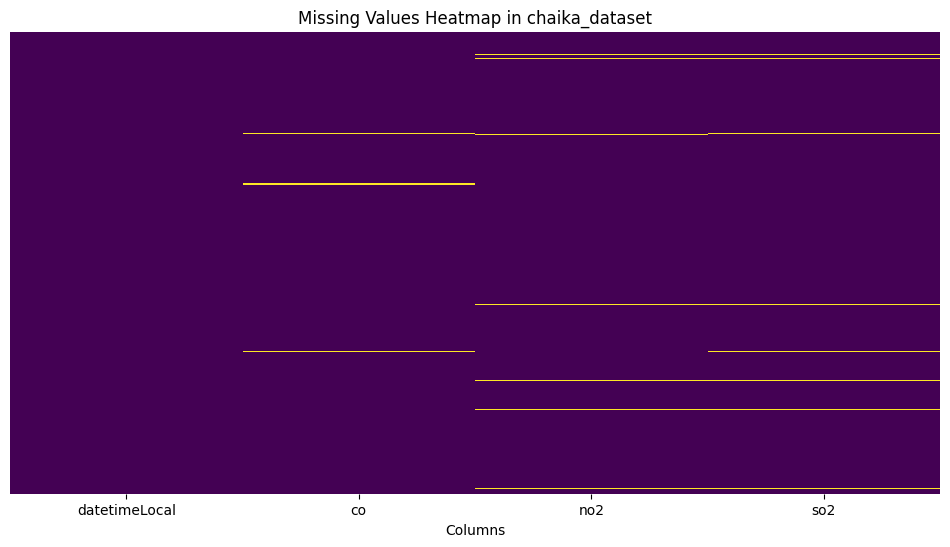

In [2396]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(chaika_dataset.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in chaika_dataset')
plt.xlabel('Columns')
plt.show()

What is noticeable here is that although there is little data missing, not all pollutants from the previous dataset are present.

### Angel Kanchev-Varna (part 2)
Let's do the same here for the next station.

In [2397]:
angel1 = pandas.read_csv('datasets/openaq_location_8843_measurments.csv')
angel1.shape

(6000, 15)

In [2398]:
angel2 = pandas.read_csv('datasets/openaq_location_8843_measurments (1).csv')
angel2.shape

(2829, 15)

In [2399]:
angel3 = pandas.read_csv('datasets/openaq_location_8843_measurments (2).csv')
angel3.shape

(3727, 15)

In [2400]:
angel4 = pandas.read_csv('datasets/openaq_location_8843_measurments (3).csv')
angel4.shape

(2871, 15)

In [2401]:
angel5 = pandas.read_csv('datasets/openaq_location_8843_measurments (4).csv')
angel5.shape

(2724, 15)

In [2402]:
angel_dataset = pandas.concat([angel1, angel2, angel3, angel4, angel5])

In [2403]:
angel_dataset.shape

(18151, 15)

In [2404]:
angel_dataset = angel_dataset.pivot_table(
    index='datetimeLocal',
    columns='parameter',
    values='value'
).reset_index()

angel_dataset

parameter,datetimeLocal,co,no2,o3,pm10,pm25,so2
0,2025-01-01T20:00:00+02:00,1180.0,95.40,7.74,51.87,51.69,16.57
1,2025-01-02T01:00:00+02:00,490.0,34.49,37.32,44.20,12.47,16.00
2,2025-01-02T02:00:00+02:00,570.0,52.76,19.50,37.13,16.54,16.01
3,2025-01-02T11:00:00+02:00,650.0,70.78,25.91,34.11,21.86,16.45
4,2025-01-02T12:00:00+02:00,720.0,80.30,24.58,35.74,27.21,16.53
...,...,...,...,...,...,...,...
3070,2025-06-19T05:00:00+03:00,350.0,7.46,50.75,10.97,5.82,10.19
3071,2025-06-19T06:00:00+03:00,350.0,7.30,46.95,8.71,5.20,11.06
3072,2025-06-19T07:00:00+03:00,330.0,15.55,41.18,12.10,5.40,10.68
3073,2025-06-19T09:00:00+03:00,720.0,107.43,9.54,20.52,8.29,10.64


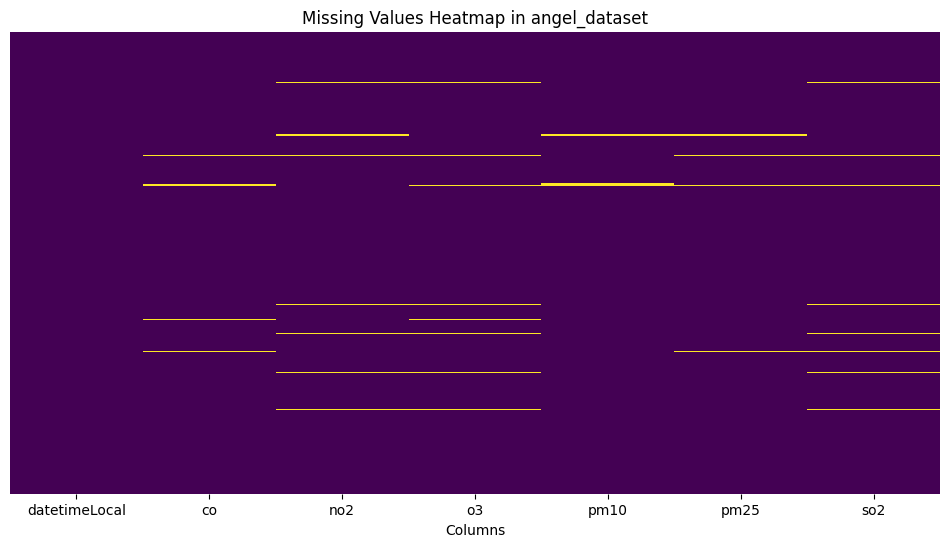

In [2405]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(angel_dataset.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in angel_dataset')
plt.xlabel('Columns')
plt.show()

Compared to the previous dataset from Chaika, there are more pollutants, but some are still missing. 

Let's combine all of them to see the final result.

## Combination of all CSV files 📥

In [2406]:
final_combined_df = pandas.concat([chaika_dataset, angel_dataset, combined_df])

In [2407]:
print("The API key and csv file datasets contain: " + str(final_combined_df.shape))

The API key and csv file datasets contain: (6527, 9)


In [2408]:
final_combined_df.sample(10)

,datetimeLocal,co,no2,so2,o3,pm10,pm25,datetime_from_local,no
1715,2025-04-03T06:00:00+03:00,420.0,5.27,9.47,76.77,16.12,3.93,NaN,NaN
653,2025-02-05T16:00:00+02:00,NaN,NaN,NaN,NaN,21.84,NaN,NaN,NaN
616,2025-02-04T11:00:00+02:00,660.0,16.67,7.20,NaN,NaN,NaN,NaN,NaN
3028,2025-06-14T17:00:00+03:00,290.0,5.63,13.27,76.55,14.38,6.58,NaN,NaN
2736,2025-05-30T00:00:00+03:00,510.0,14.98,-1.00,NaN,NaN,NaN,NaN,NaN
631,2025-02-05T02:00:00+02:00,590.0,8.73,6.44,NaN,NaN,NaN,NaN,NaN
1694,2025-04-03T00:00:00+03:00,730.0,17.47,9.98,NaN,NaN,NaN,NaN,NaN
262,2025-01-17T22:00:00+02:00,630.0,80.40,17.40,21.34,34.78,14.57,NaN,NaN
875,2025-02-15T16:00:00+02:00,490.0,6.50,18.52,36.17,24.03,15.34,NaN,NaN
3002,2025-06-14T12:00:00+03:00,440.0,6.97,-1.00,NaN,NaN,NaN,NaN,NaN


## Data Dictionary 📖

Below is a **data dictionary** with descriptions for the final key variables used in this dataset:

| No. | Column Name                 | Unit                  | Description                                                                 |
|-----|-----------------------------|-----------------------|-----------------------------------------------------------------------------|
| 1   | `co`                        | parts per million(ppm)| Concentration of carbon monoxide (CO).                                      |
| 2   | `no2`                       | µg/m³                 | Concentration of nitrogen dioxide (NO₂).                                    |
| 3   | `so2`                       | µg/m³                 | Concentration of sulfur dioxide (SO₂).                                      |
| 4   | `o3`                        | µg/m³                 | Concentration of ozone (O₃).                                                |
| 5   | `pm10`                      | µg/m³                 | Concentration of particulate matter (PM₁₀).                                 |
| 6   | `pm25`                      | µg/m³                 | Concentration of particulate matter (PM₂.₅).                                |
| 7   | `no`                        | µg/m³                 | Concentration of nitrogen monoxide (NO).                                    |
| 8   | `datetimeLocal/datetime_from_local` | datetime      | Local date and time of the measurement.                                     |
| 9   | `AQI`                       | unitless              | Air Quality Index (AQI) value calculated based on pollutant concentrations. |
| 10  | `AQI_Category`              | categorical           | Qualitative category of air quality based on AQI values.                    |

⚠️ Not all variables were used in the final model. Several columns were excluded during the cleaning and feature selection process due to missing values, low variance, or low correlation with the target variable (see EDA section for justification).

## Preprocessing 🛠️

### Format dates 🗓️

It is evident that the columns "datetimeLocal" and "datetime_from_local" cannot co-exist since they represent the same data. Therefore, it is logical to combine them into a single column.

In [2409]:
final_combined_df['datetime_local'] = final_combined_df['datetime_from_local'].combine_first(final_combined_df['datetimeLocal'])
final_combined_df.drop(columns=['datetime_from_local', 'datetimeLocal'], inplace=True)

In [2410]:
final_combined_df.dtypes

co                float64
no2               float64
so2               float64
o3                float64
pm10              float64
pm25              float64
no                float64
datetime_local     object
dtype: object

In [2411]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], utc=True)
print(final_combined_df.dtypes)

co                            float64
no2                           float64
so2                           float64
o3                            float64
pm10                          float64
pm25                          float64
no                            float64
datetime_local    datetime64[ns, UTC]
dtype: object


In [2412]:
final_combined_df['datetime_local'] = pandas.to_datetime(final_combined_df['datetime_local'], errors='coerce')
final_combined_df['datetime_local'] = final_combined_df['datetime_local'].dt.strftime('%Y-%m-%d %H:%M')

In [2413]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,no,datetime_local
2510,410.0,1.80,6.29,67.84,22.34,6.46,NaN,2025-05-16 01:00
961,460.0,18.92,18.93,72.63,11.99,11.10,NaN,2025-02-19 16:00
2351,450.0,9.39,11.55,NaN,NaN,NaN,NaN,2025-05-09 18:00
2942,480.0,7.75,-1.00,NaN,NaN,NaN,NaN,2025-06-10 21:00
635,570.0,8.64,6.19,NaN,NaN,NaN,NaN,2025-02-05 04:00
972,640.0,15.88,8.62,NaN,NaN,NaN,NaN,2025-02-20 18:00
1521,640.0,8.50,9.06,NaN,NaN,NaN,NaN,2025-03-24 11:00
1965,430.0,7.00,8.49,NaN,NaN,NaN,NaN,2025-04-15 16:00
2695,470.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-05-27 18:00
2003,440.0,7.17,8.90,NaN,NaN,NaN,NaN,2025-04-17 11:00


### Null values 0️⃣

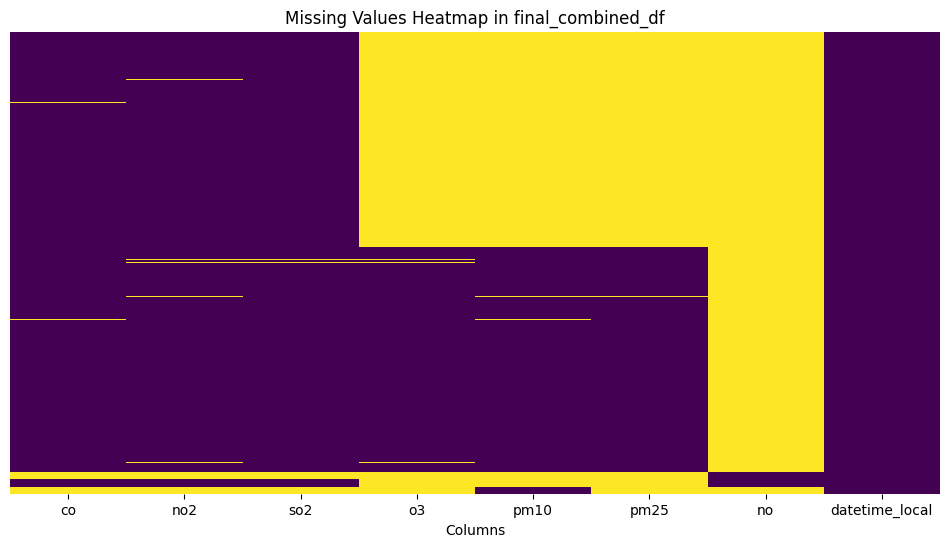

In [2414]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [2415]:
missing_percent = final_combined_df.isnull().mean() * 100
print(missing_percent.sort_values(ascending=False))

no                96.935805
o3                52.290486
pm25              52.014708
pm10              50.375364
no2                4.703539
so2                4.473725
co                 3.968132
datetime_local     0.000000
dtype: float64


Since **nitric oxide (NO)** is missing in nearly 97% of the dataset, I believe it is not very important and should not be included. I will only retain values that have a presence of more than 30% in the dataset, as those have a valid reason for being kept. Even partial data can capture trends or patterns.

To better understand each value, I will explain them one by one, chemical by chemical:

**PM2.5 (Fine Particulate Matter)**
- One of the most dangerous air pollutants. Often a major driver of AQI values.
- Can penetrate deep into the lungs and even enter the bloodstream. Linked to respiratory and cardiovascular diseases, premature death and cancer.

**PM10 (Inhalable Particulate Matter)**
- Can cause respiratory irritation, lung function decline and worsen conditions like asthma and bronchitis.

**O₃ (Ground-level Ozone)**
- Not emitted directly; formed by chemical reactions between NOx and VOCs in sunlight.
- Causes chest pain, coughing, throat irritation, and worsens asthma and other lung diseases.
- Major component of smog; more problematic during sunny, hot weather.

**SO₂ (Sulfur Dioxide)**
- Burning of coal and oil, especially from power plants and ships.
- Causes respiratory symptoms and aggravates conditions like asthma.
- Can lead to acid rain and contributes to PM formation; more of a concern in industrial areas or near ports.

**CO (Carbon Monoxide)**
- Incomplete combustion from cars, stoves and heaters.
- Reduces oxygen delivery in the body, can be fatal at very high levels; particularly dangerous indoors.
- Usually less of a concern outdoors unless near heavy traffic or in enclosed urban canyons.

**NO₂ (Nitrogen Dioxide)**
- Combustion engines (cars, trucks, etc), power plants.
- Irritates airways, reduces lung function, and increases the risk of respiratory infections.
- Key indicator of traffic-related air pollution; contributes to the formation of PM and ozone.

**NO (Nitric Oxide)**
- Emitted directly from vehicles and industrial activity.
- Less directly harmful, but quickly converts into **NO₂**, which is more dangerous.

So since we have enough of the **NO₂**, discarding **NO** is fine, due to the following reasons:
- **NO** and **NO₂** are chemically linked and often reported together as NOx (nitrogen oxides).
- **NO₂** is the more harmful and relevant pollutant for health and AQI. It is usually used directly in AQI calculation, not **NO**.
- **NO** is a precursor to **NO₂** and ozone, but if you already have **NO₂** (which reflects both traffic-related emissions and photochemical activity), we are already capturing the more critical part of the picture.

sources: 
- https://ww2.arb.ca.gov/resources/nitrogen-dioxide-and-health#:~:text=Air%20quality%20regulators%20have%20selected,X%20emissions%20as%20a%20group
- https://en.wikipedia.org/wiki/NOx#:~:text=In%20atmospheric%20chemistry%2C%20the%20term,to%20again%20form%20NO%202

In [2416]:
threshold = 0.7
final_combined_df = final_combined_df.loc[:, final_combined_df.isnull().mean() < threshold]

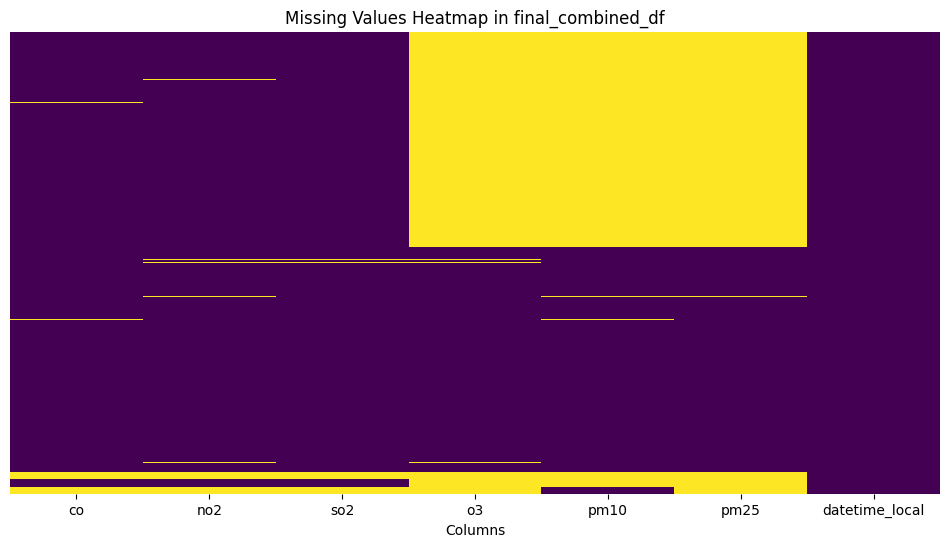

In [2417]:
plt.figure(figsize=(12, 6))
seaborn.heatmap(final_combined_df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap in final_combined_df')
plt.xlabel('Columns')
plt.show()

In [2418]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local
207,680.0,10.33,6.33,NaN,NaN,NaN,2025-01-12 22:00
1721,470.0,7.64,8.63,NaN,NaN,NaN,2025-04-04 04:00
70,700.0,13.88,6.57,NaN,NaN,NaN,2025-01-05 05:00
576,430.0,5.04,18.57,25.33,18.47,17.67,2025-02-01 23:00
2775,310.0,21.05,10.46,52.06,15.99,8.30,2025-05-30 14:00
953,740.0,12.53,6.89,NaN,NaN,NaN,2025-02-19 23:00
2291,520.0,6.92,12.01,NaN,NaN,NaN,2025-05-06 14:00
1435,500.0,8.30,8.51,NaN,NaN,NaN,2025-03-20 16:00
1606,390.0,3.73,8.49,98.28,27.12,8.28,2025-03-28 12:00
718,440.0,6.87,18.72,40.21,13.36,8.12,2025-02-08 10:00


Since several key features like **O₃**, **PM2.5** and **PM10** have more than 50% missing values, we apply mean imputation to handle missing values in key pollutant features, ensuring dataset completeness while preserving the overall data distribution for model training.

In [2419]:
# imputer = SimpleImputer(strategy='mean') 
# final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']] = imputer.fit_transform(
#     final_combined_df[['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']]
# )

After testing the models, I found overfitting due to imputation. To prevent this, I decided to drop the non-value data instead. That is why I commented the block of code.

In [2420]:
final_combined_df = final_combined_df.dropna(subset=['co', 'no2', 'so2', 'o3', 'pm10', 'pm25'])

In [2421]:
final_combined_df.isnull().sum()

co                0
no2               0
so2               0
o3                0
pm10              0
pm25              0
datetime_local    0
dtype: int64

Finally, here is the result no missing values.

The issue with the missing data arises from the outdated measurments provided by the API key, as well as the fact that both stations do not collect the same measurements. To address this, I utilized the CSV files. The data for 2025 is much more complete and up-to-date, making it a better choice for the model and the final results.

## Sample the data 📃

In [2422]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local
213,500.0,12.46,17.05,40.89,16.71,16.89,2025-01-12 22:00
1387,550.0,34.03,11.01,13.67,37.26,24.42,2025-03-17 15:00
1832,500.0,19.77,8.67,93.23,23.24,9.20,2025-04-08 17:00
2454,450.0,33.16,5.44,59.21,12.50,8.96,2025-05-13 13:00
2705,350.0,18.24,4.98,2.43,8.51,4.60,2025-05-27 04:00
1911,400.0,3.64,8.77,95.38,13.59,5.56,2025-04-12 13:00
2340,430.0,31.92,4.65,9.89,15.60,10.18,2025-05-08 06:00
2997,350.0,13.02,14.13,81.26,24.81,12.67,2025-06-12 11:00
2799,330.0,10.34,8.99,70.15,7.79,8.72,2025-05-31 19:00
2234,390.0,1.11,9.55,95.27,11.26,2.97,2025-04-29 01:00


## Calculating AQI 🧮
At the moment there is no present target variable from this data, however the data is enough to calculate the AQI sub-index for a given pollutant concentration, based on a list of breakpoint ranges. Then, it rounds the result to the nearest whole number (since AQI is usually reported as an integer). If no breakpoint matches, it returns None

In [2423]:
def get_subindex(concentration, breakpoints):
    for Clow, Chigh, Ilow, Ihigh in breakpoints:
        if Clow <= concentration <= Chigh:
            return round((Ihigh - Ilow) / (Chigh - Clow) * (concentration - Clow) + Ilow)
    return None

The following block defines breakpoints for the air pollutants. These are used to map pollutant concentration levels to AQI sub-index values, according to air quality standards. 

Each list of breakpoints contains tuples with 4 values:

**(Concentration_low, Concentration_high, AQI_low, AQI_high)**

These represent a range of pollutant concentration values and the corresponding AQI values.

I got it from United States Environmental Protection Agency (https://aqs.epa.gov/aqsweb/documents/codetables/aqi_breakpoints.html)

In [2424]:
pm25_breakpoints = [
    (0.0, 9.0, 0, 50),             # Good
    (9.1, 35.4, 51, 100),          # Moderate
    (35.5, 55.4, 101, 150),        # Unhealthy for sensitive groups
    (55.5, 125.4, 151, 200),       # Unhealthy
    (125.5, 225.4, 201, 300),      # Very Unhealthy
    (225.5, 325.4, 301, 400),      # Hazardous
    (325.5, 99999.9, 401, 500)     # Extended Hazardous
]
pm10_breakpoints = [
    (0, 54, 0, 50),                # Good
    (55, 154, 51, 100),            # Moderate
    (155, 254, 101, 150),          # Unhealthy for sensitive groups
    (255, 354, 151, 200),          # Unhealthy
    (355, 424, 201, 300),          # Very Unhealthy
    (425, 604, 301, 500),          # Hazardous
    (605, 99999.9, 501, 999)       # Extended Hazardous
]
o3_breakpoints = [      
    (0, 54, 0, 50),                # Good    
    (55, 70, 51, 100),             # Moderate    
    (71, 85, 101, 150),            # Unhealthy for sensitive groups  
    (86, 105, 151, 200),           # Unhealthy
    (106, 200, 201, 300)           # Very Unhealthy
]
co_breakpoints = [
    (0.0, 4.4, 0, 50),             # Good
    (4.5, 9.4, 51, 100),           # Moderate
    (9.5, 12.4, 101, 150),         # Unhealthy for sensitive groups
    (12.5, 15.4, 151, 200),        # Unhealthy
    (15.5, 30.4, 201, 300),        # Very Unhealthy
    (30.5, 50.4, 301, 500),        # Hazardous
    (50.5, 99999.9, 501, 999)      # Extended Hazardous
]
no2_breakpoints = [
    (0, 53, 0, 50),                # Good
    (54, 100, 51, 100),            # Moderate
    (101, 360, 101, 150),          # Unhealthy for sensitive groups
    (361, 649, 151, 200),          # Unhealthy
    (650, 1249, 201, 300),         # Very Unhealthy
    (1250, 2049, 301, 500),        # Hazardous
    (2050, 99999, 501, 999)        # Extended Hazardous
]
so2_breakpoints = [
    (0, 35, 0, 50),                # Good
    (36, 75, 51, 100),             # Moderate
    (76, 185, 101, 150),           # Unhealthy for sensitive groups
    (186, 304, 151, 200),          # Unhealthy
    (305, 99999, 201, 300)         # Very Unhealthy
]

To quantify overall air quality, we calculate the AQI for each row based on six key pollutants: PM2.5, PM10, O₃, CO, NO₂ and SO₂. For each pollutant, we compute a sub-index AQI using EPA-defined breakpoints and a standard formula that linearly maps pollutant concentrations to the AQI scale. 

CO concentrations are converted from µg/m³ to mg/m³ to match the units of its breakpoints. 

Only non-missing pollutant values are considered and the final AQI for each row is determined by taking the maximum of the available sub-indices, reflecting the pollutant posing the greatest health risk at that point in time. This process results in a single AQI value per observation, representing the overall air quality based on the most harmful pollutant present.

In [2425]:
def calculate_row_aqi(row):
    aqi_values = []
    
    if not pandas.isnull(row['pm25']):
        aqi_values.append(get_subindex(row['pm25'], pm25_breakpoints))
    if not pandas.isnull(row['pm10']):
        aqi_values.append(get_subindex(row['pm10'], pm10_breakpoints))
    if not pandas.isnull(row['o3']):
        aqi_values.append(get_subindex(row['o3'], o3_breakpoints))
    if not pandas.isnull(row['co']):
        aqi_values.append(get_subindex(row['co'] / 1000, co_breakpoints))  # µg/m³ to mg/m³
    if not pandas.isnull(row['no2']):
        aqi_values.append(get_subindex(row['no2'], no2_breakpoints))
    if not pandas.isnull(row['so2']):
        aqi_values.append(get_subindex(row['so2'], so2_breakpoints))
    
    return max([aqi for aqi in aqi_values if aqi is not None], default=None)

final_combined_df['AQI'] = final_combined_df.apply(calculate_row_aqi, axis=1)

To make the AQI values more interpretable, we classify them into standard health-related categories using this function, which assigns each AQI to a label based on U.S. EPA guidelines (https://www3.epa.gov/ttn/ozonehealth/figure14.html).

The result is stored in a new column called "AQI_Category", making it easy to group and visualize air quality conditions across different records.

In [2426]:
def aqi_category(aqi):
    if aqi is None:
        return 'Unknown'
    elif aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

final_combined_df['AQI_Category'] = final_combined_df['AQI'].apply(aqi_category)

In [2427]:
final_combined_df['AQI_Category'].value_counts()

AQI_Category
Moderate                          1492
Unhealthy for Sensitive Groups     556
Good                               497
Unhealthy                          327
Hazardous                          152
Very Unhealthy                      57
Name: count, dtype: int64

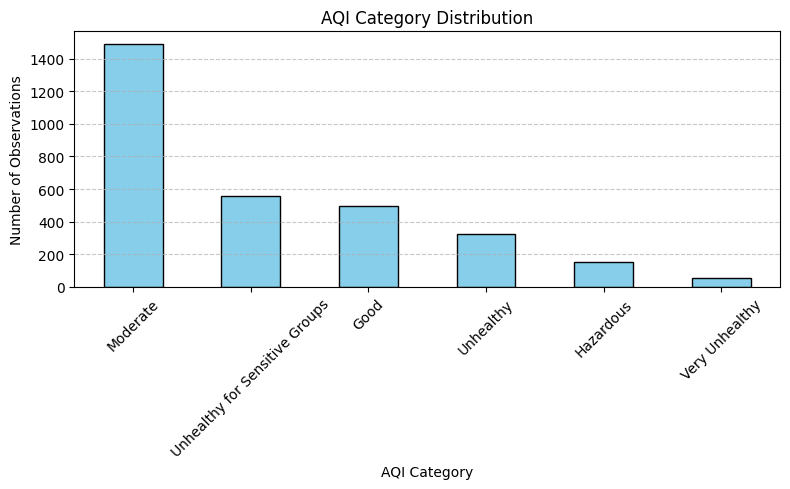

In [2428]:
category_counts = final_combined_df['AQI_Category'].value_counts()

plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('AQI Category Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The "Moderate" AQI category has the highest number of observations, which is a common outcome in urban air quality datasets. This reflects typical, day-to-day air conditions where pollutant levels are elevated due to vehicle traffic, household activities and mild industrial emissions, but not high enough to trigger health warnings for the general population. In many environments, especially outside of extreme weather events or major pollution incidents, air quality tends to fluctuate within this moderate range. This suggests that while the air may not be perfectly clean, it is generally acceptable for most people, with only limited risk for sensitive individuals.

In [2429]:
final_combined_df.isnull().sum()

co                  0
no2                 0
so2                 0
o3                  0
pm10                0
pm25                0
datetime_local      0
AQI               152
AQI_Category        0
dtype: int64

In [2430]:
final_combined_df = final_combined_df.dropna(subset=['AQI'])

In [2431]:
final_combined_df.sample(10)

,co,no2,so2,o3,pm10,pm25,datetime_local,AQI,AQI_Category
2071,400.0,15.47,10.56,90.54,17.17,4.37,2025-04-19 16:00,163.0,Unhealthy
705,390.0,2.10,19.67,53.35,14.73,9.71,2025-02-07 21:00,52.0,Moderate
1419,460.0,7.32,12.14,50.29,10.81,7.23,2025-03-19 06:00,47.0,Good
272,550.0,45.46,16.49,32.04,17.21,18.52,2025-01-18 08:00,69.0,Moderate
2420,380.0,7.08,4.26,48.12,11.99,5.23,2025-05-12 00:00,45.0,Good
190,320.0,4.51,17.26,49.07,27.33,0.47,2025-01-11 00:00,45.0,Good
1841,620.0,88.43,8.51,51.80,40.92,13.73,2025-04-09 07:00,88.0,Moderate
1858,630.0,87.03,8.86,33.34,25.94,11.05,2025-04-10 05:00,86.0,Moderate
2497,430.0,20.86,9.11,62.45,20.62,6.19,2025-05-15 12:00,75.0,Moderate
2263,390.0,10.12,8.04,111.54,21.14,3.58,2025-04-30 14:00,207.0,Very Unhealthy


## Data Analysis and Visualization 📊

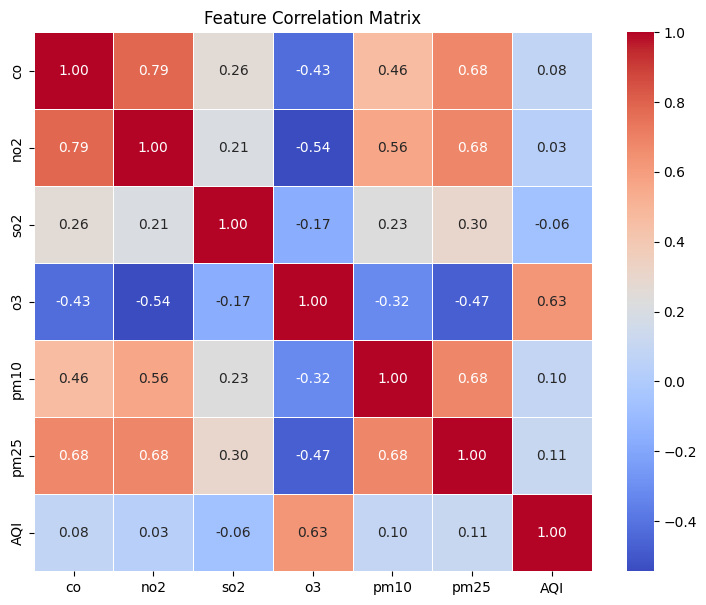

In [2432]:
numeric_df = final_combined_df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(9, 7))
seaborn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title('Feature Correlation Matrix')
plt.show()

This is a correlation matrix heatmap showing the relationships between various air quality features: carbon monoxide (co), nitrogen dioxide (no2), sulfur dioxide (so2), ozone (o3), particulate matter ≤10μm (pm10), particulate matter ≤2.5μm (pm25) and the Air Quality Index (AQI). Each cell contains the Pearson correlation coefficient between two features, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation). Red shades indicate strong positive correlations, blue shades indicate strong negative correlations and neutral colors show weak or no correlation.

**Key observations:**
- co and no2 have a strong positive correlation (0.79), meaning they tend to increase or decrease together.
- pm10 and pm25 are also strongly positively correlated (0.68), reflecting their similar sources and behavior.
- o3 is negatively correlated with no2 (-0.54) and pm25 (-0.47), indicating that as ozone increases, these pollutants tend to decrease.
- AQI has a moderate positive correlation with o3 (0.63), suggesting ozone levels significantly influence air quality in this dataset.
- Other correlations, such as AQI with co, no2, so2, pm10 and pm25, are weak (close to zero).

This matrix helps identify which pollutants are closely related, which can inform air quality analysis and modeling.

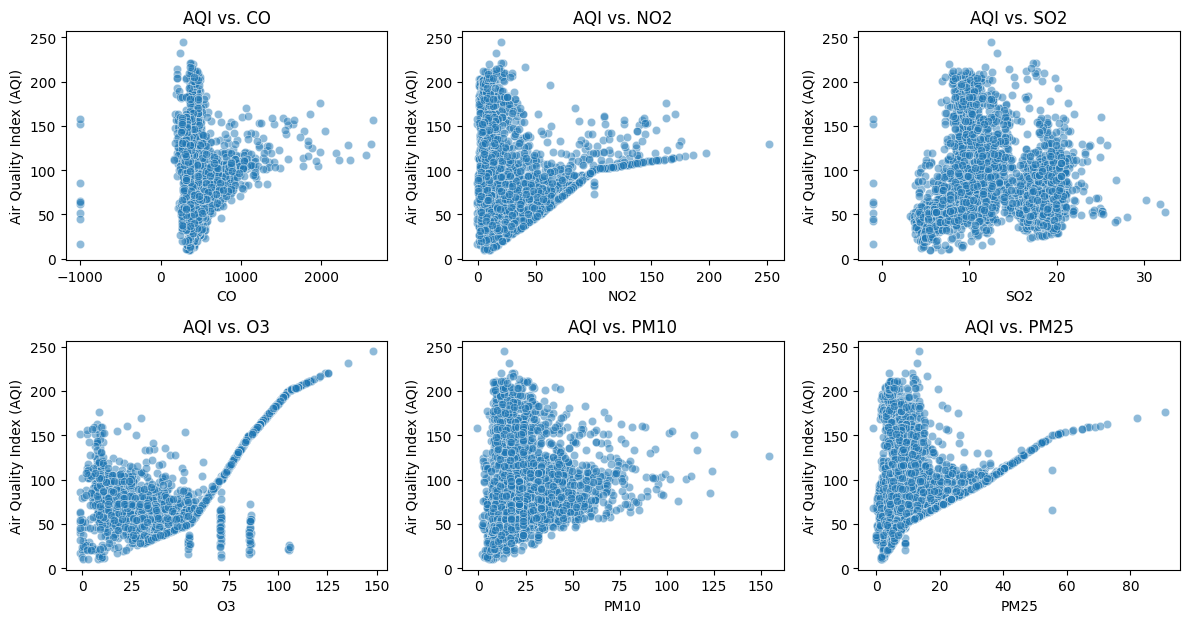

In [2433]:
air_quality_features = ["co", "no2", "so2", "o3", "pm10", "pm25"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
axes = axes.flatten()

for i, feature in enumerate(air_quality_features):
    seaborn.scatterplot(
        x=final_combined_df[feature],
        y=final_combined_df["AQI"], 
        alpha=0.5,
        ax=axes[i] 
    )
    axes[i].set_xlabel(feature.upper())
    axes[i].set_ylabel("Air Quality Index (AQI)")
    axes[i].set_title(f"AQI vs. {feature.upper()}")

for j in range(len(air_quality_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

These scatter plots show the relationship between the Air Quality Index (AQI) and six air pollutants: carbon monoxide (CO), nitrogen dioxide (NO2), sulfur dioxide (SO2), ozone (O3), particulate matter ≤10μm (PM10) and particulate matter ≤2.5μm (PM25). Each point represents a data sample, with the pollutant concentration on the x-axis and the AQI value on the y-axis.

**Key observations:**
- CO (Carbon Monoxide): The points are widely scattered and form a triangular pattern, suggesting there is no strong or consistent relationship between CO levels and AQI in this dataset.
- NO2 (Nitrogen Dioxide): Similar to CO, the data points are spread out in a triangular shape, indicating only a weak or inconsistent relationship between NO2 and AQI.
- SO2 (Sulfur Dioxide): The points are clustered without a clear trend, showing little to no direct relationship between SO2 and AQI.
- O3 (Ozone): There is a noticeable upward trend, especially at higher ozone levels. As O3 increases, AQI also tends to increase, indicating a stronger positive relationship compared to the other pollutants.
- PM10 (Particulate Matter ≤10μm): The scatter is wide and triangular, showing a weak relationship between PM10 and AQI.
- PM25 (Particulate Matter ≤2.5μm): The pattern is similar to PM10, with a wide spread of AQI values for most PM25 concentrations, indicating a weak relationship.

Overall, these plots indicate that among the pollutants shown, ozone (O3) has the strongest visible association with AQI, while the others show weaker or less clear relationships. This suggests that, in this dataset, AQI is most sensitive to changes in ozone levels.

## Target variable 🎯

In [2434]:
features = ['co', 'no2', 'so2', 'o3', 'pm10', 'pm25']
target = 'AQI'

X = final_combined_df[features]
y = final_combined_df[target]

## Splitting into train/test 🪓
We will use 80% of the data for training and the rest - 20% for testing. This split allows the model to learn from the majority of the data while keeping a separate portion to evaluate its performance on unseen examples, helping us measure how well it generalizes.

In [2435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 2929 observations, of which 2343 are now in the train set and 586 in the test set.


## Modelling 🧬

In [2436]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Bagging': BaggingRegressor(),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LGBM': LGBMRegressor(force_col_wise=True, verbose=-1),
    'CatBoost': CatBoostRegressor(verbose=0)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    results.append((name, mae, mse, r2))

results_df = pandas.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'R²'])
results_df = results_df.sort_values('MAE')

results_df

,Model,MAE,MSE,R²
1,Random Forest,0.939283,10.873438,0.994438
5,Bagging,1.042833,14.873020,0.992392
4,Extra Trees,2.016553,33.148330,0.983044
2,XGBoost,2.861790,91.604010,0.953142
10,LGBM,2.930470,68.514247,0.964953
11,CatBoost,3.133157,64.143346,0.967189
3,Gradient Boosting,3.290642,53.113758,0.972831
7,KNN,10.268259,306.407782,0.843264
0,Linear Regression,20.455841,647.977642,0.668541
8,Ridge,20.455850,647.977804,0.668541


**Best Models**: 
- **Random Forest**: Top performer with the lowest MAE and MSE and highest R².
- **Bagging** and **Extra Trees**: Close contenders with excellent accuracy.

**Intermediate Models**: 
- **XGBoost**, **LGBM** and **CatBoost**: Reasonable performance, but slightly higher errors compared to top models.

**Underperformers**: 
- **KNN**: Moderate performance with significant errors.
- **Linear Models (Linear Regression, Ridge, Lasso)**: Poor fit for this dataset, unable to capture non-linear patterns.
- **SVR**: Worst performer with very high errors and low R².

Random Forest will be used for optimal accuracy, balancing computational efficiency and performance.


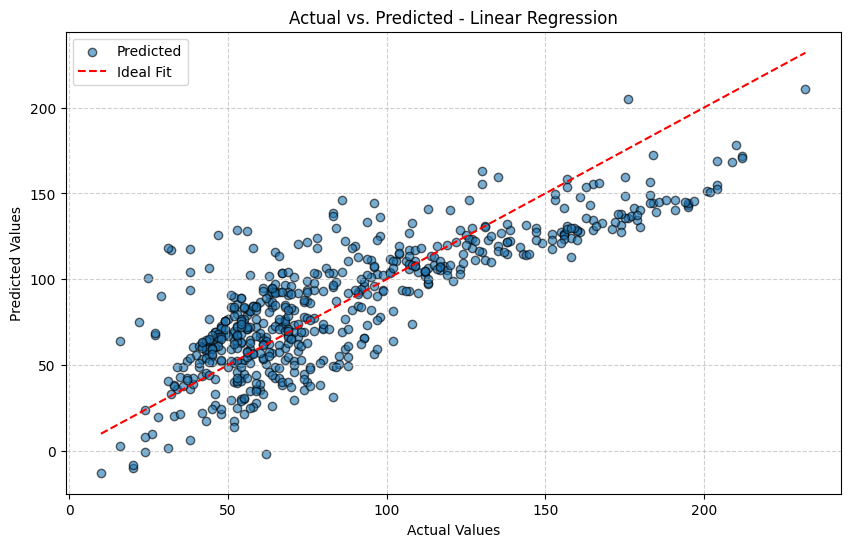

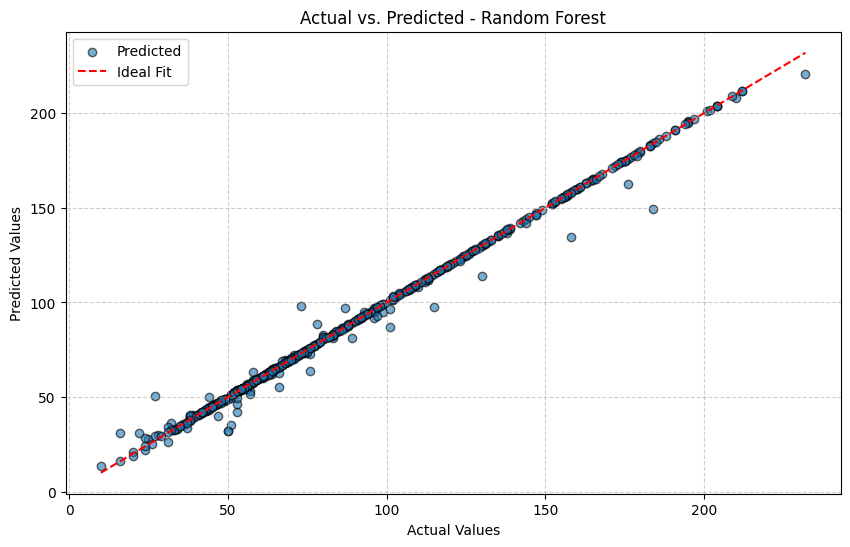

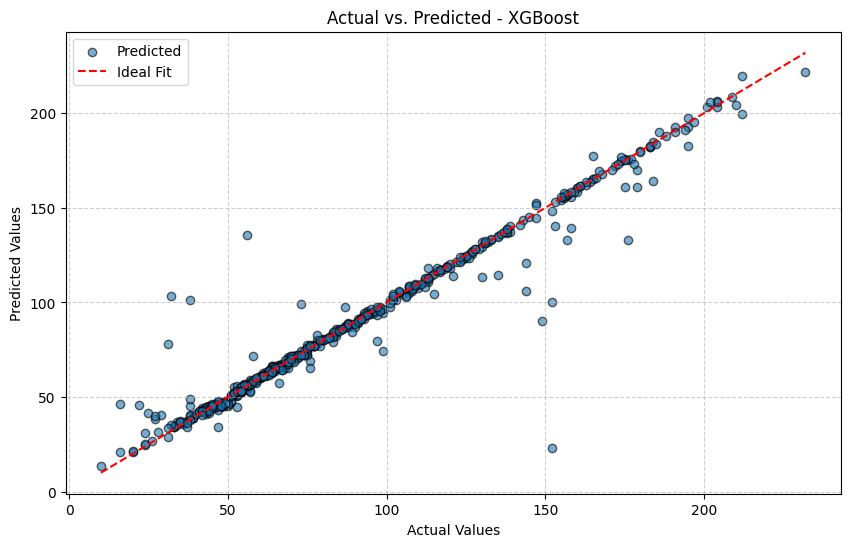

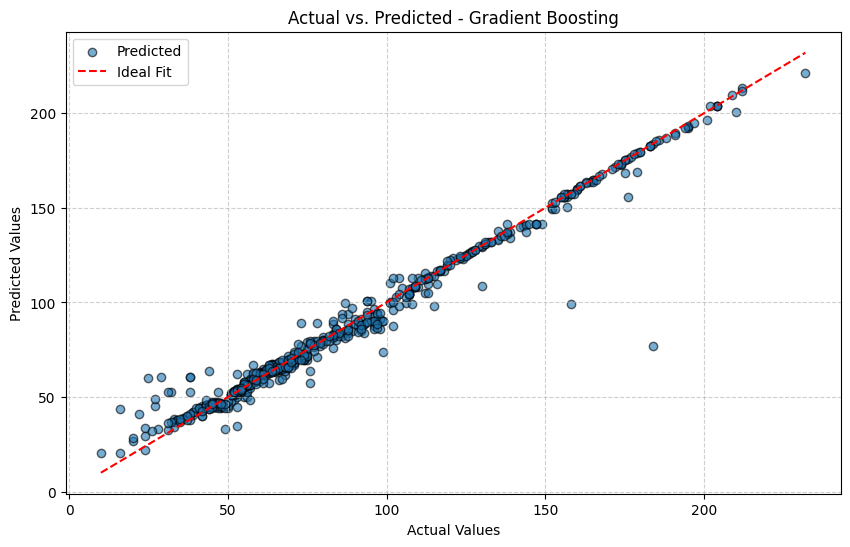

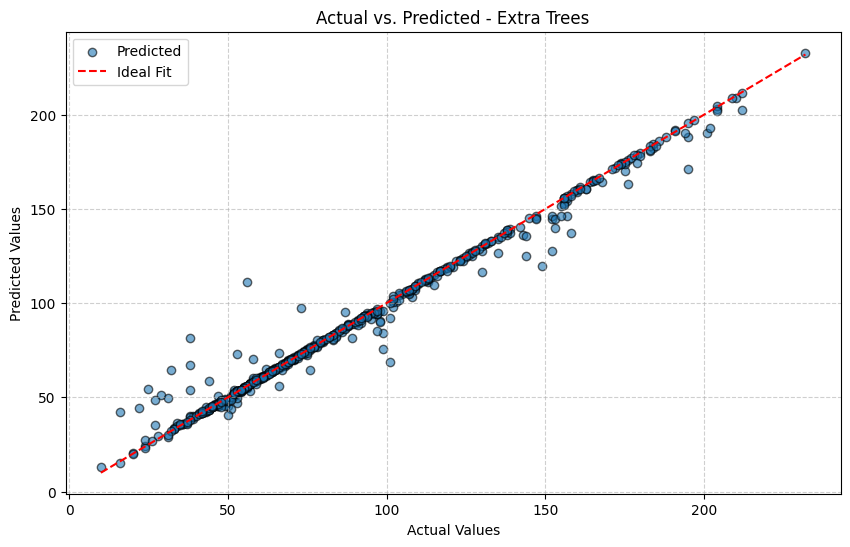

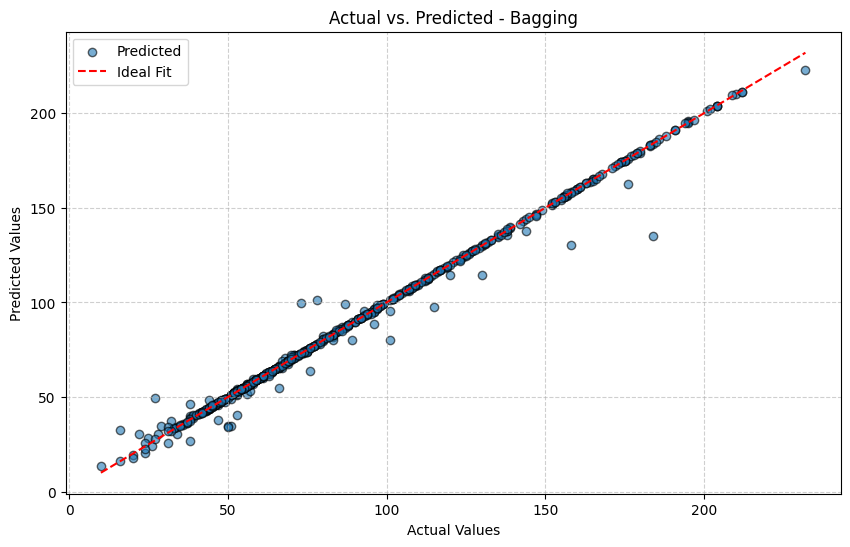

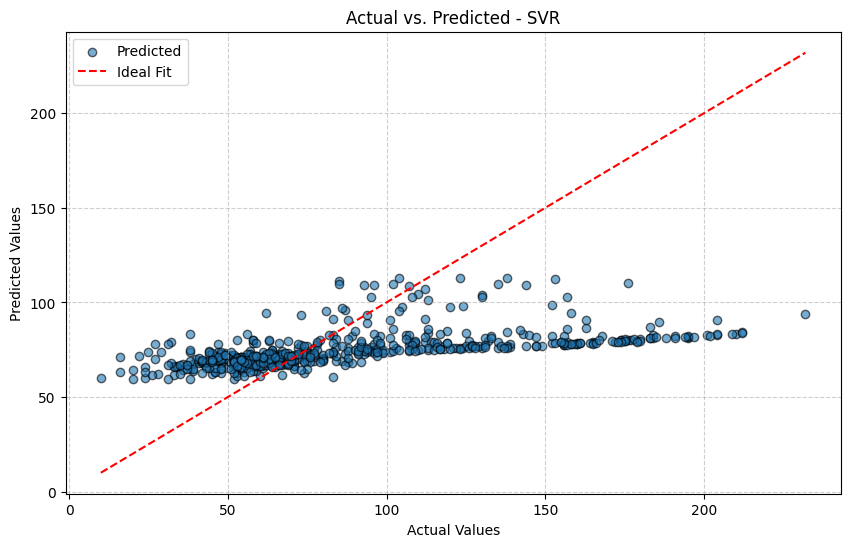

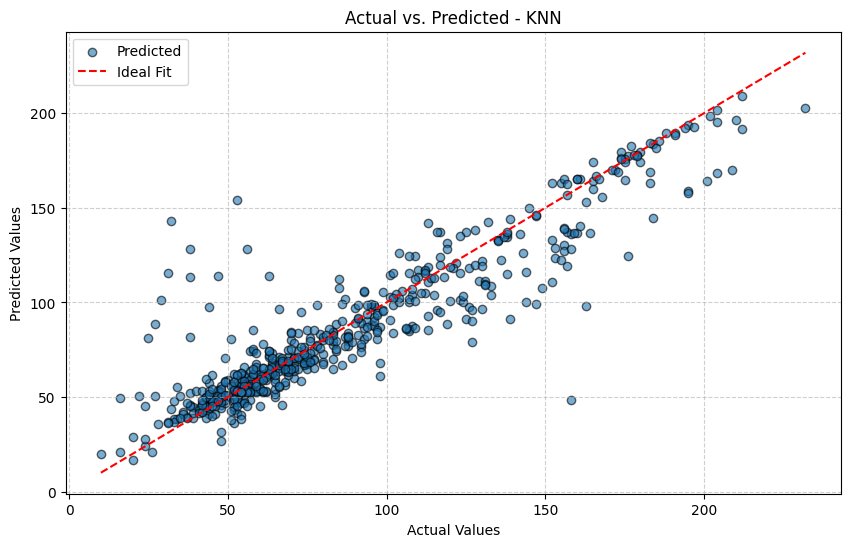

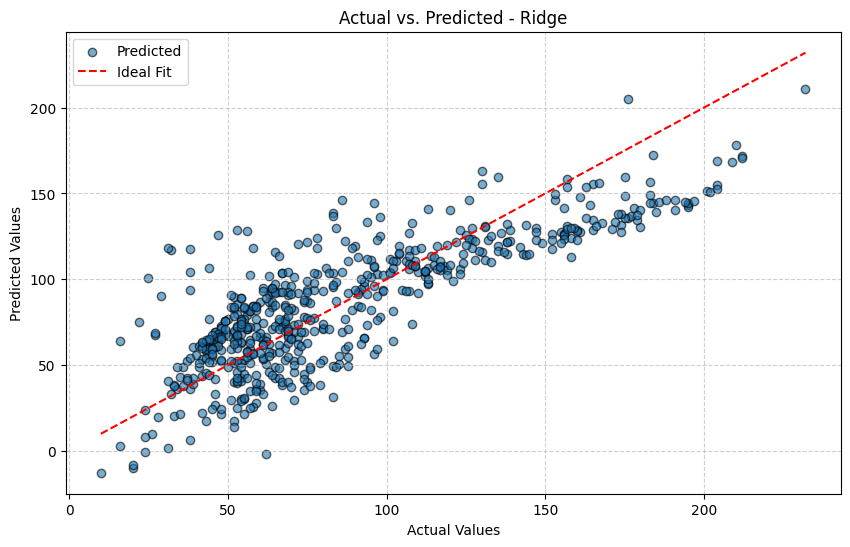

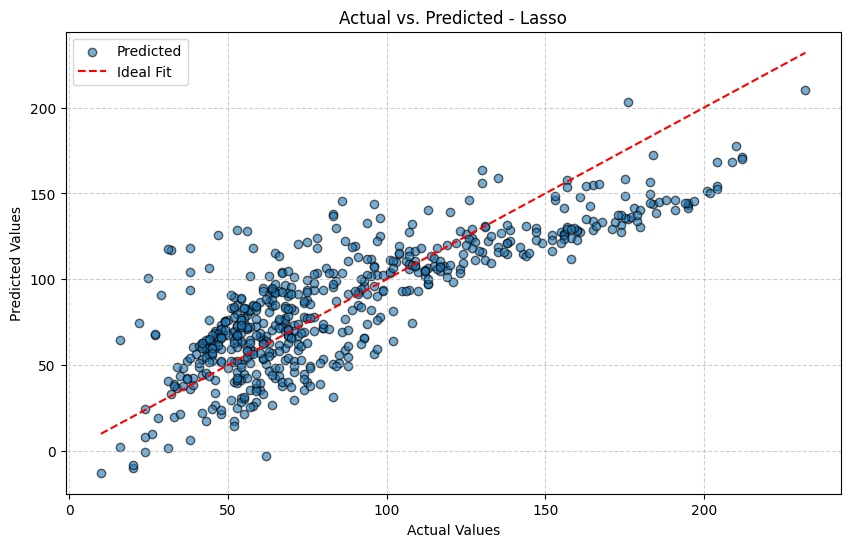

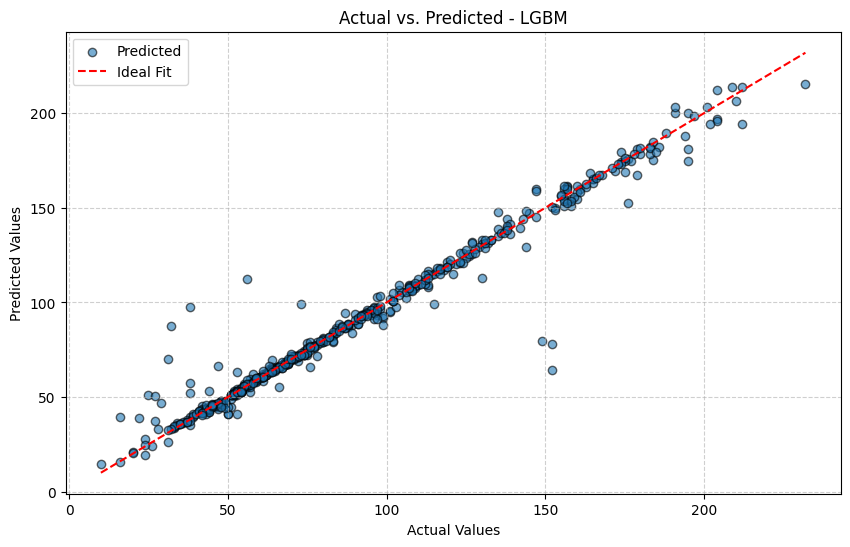

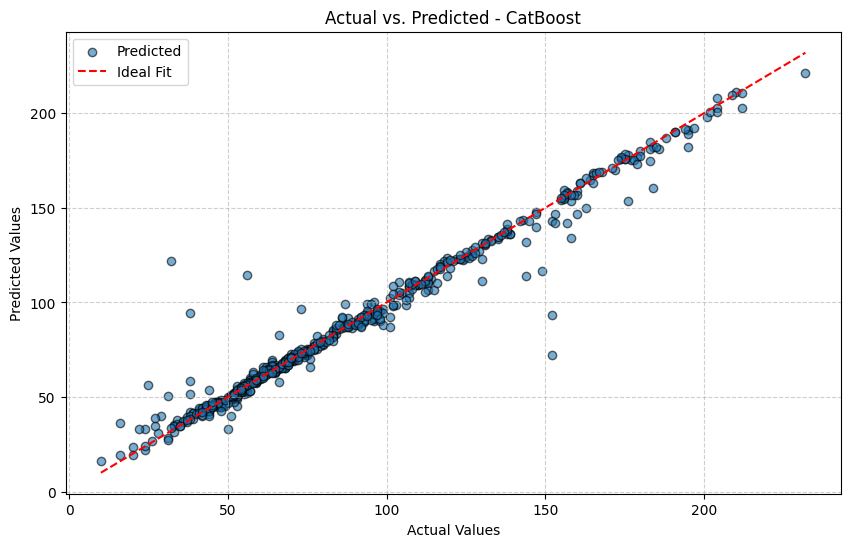

In [2438]:
for name, model in models.items():
    preds = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, preds, alpha=0.6, edgecolor='k', label='Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
    plt.title(f"Actual vs. Predicted - {name}")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

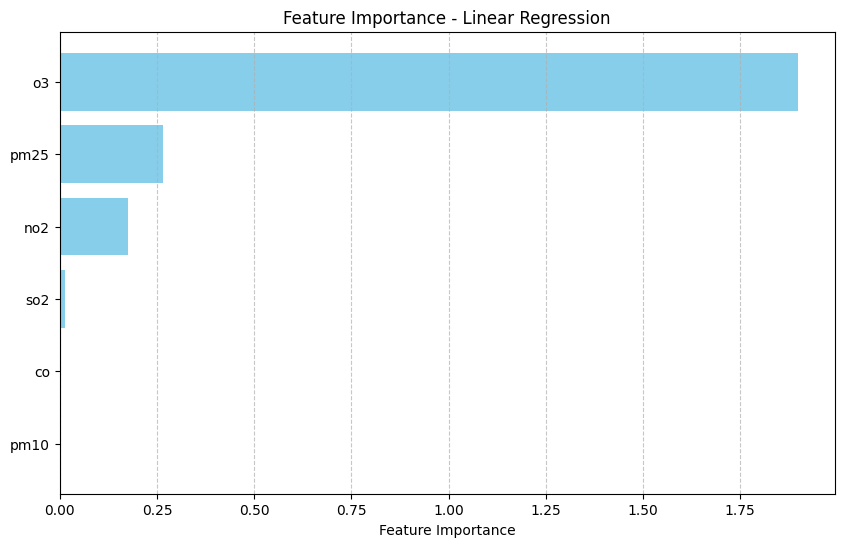

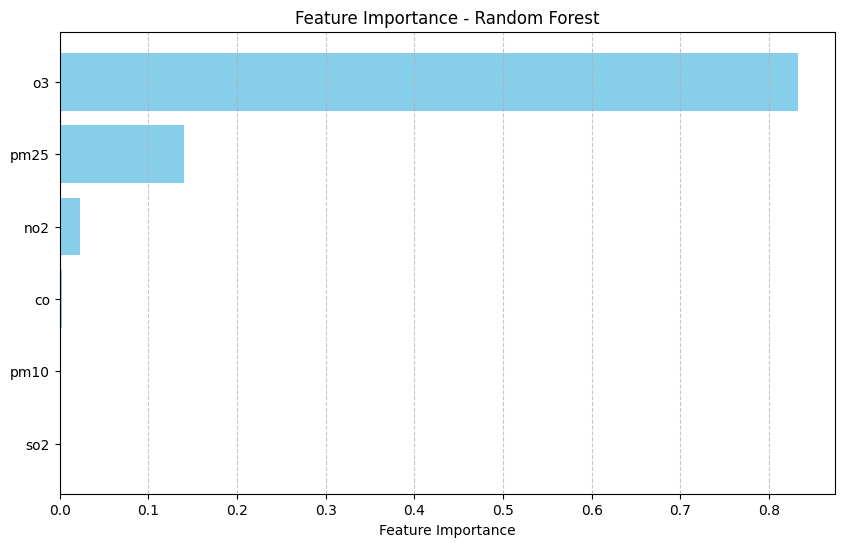

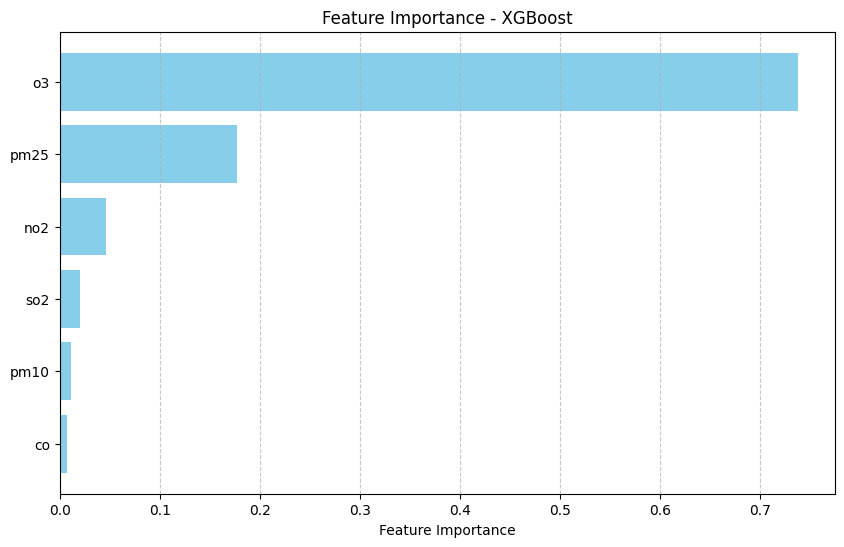

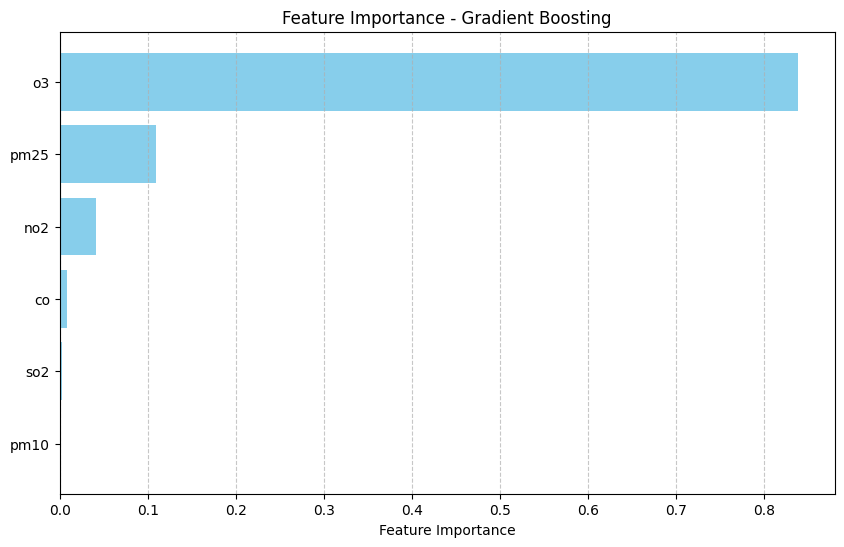

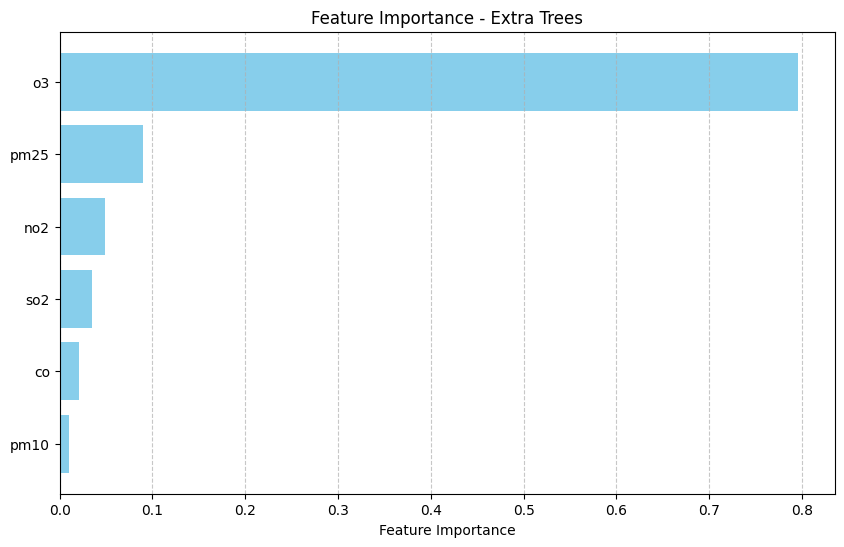

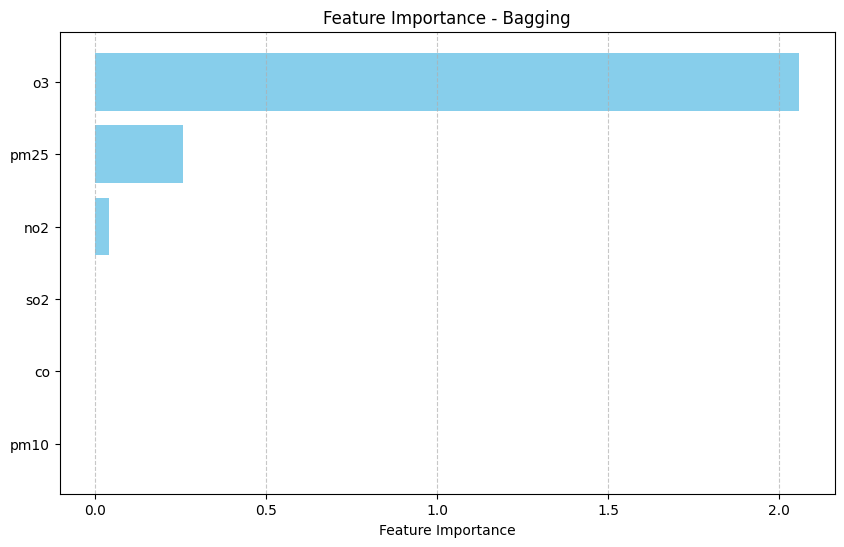

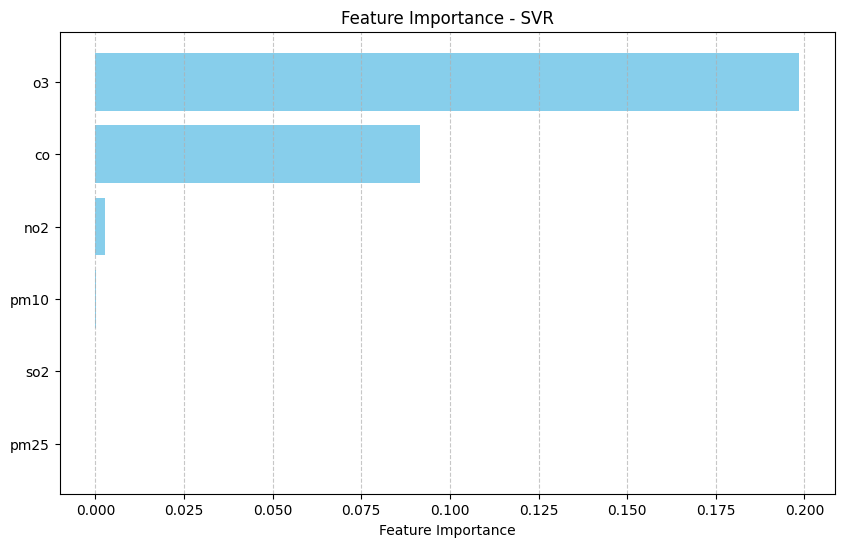

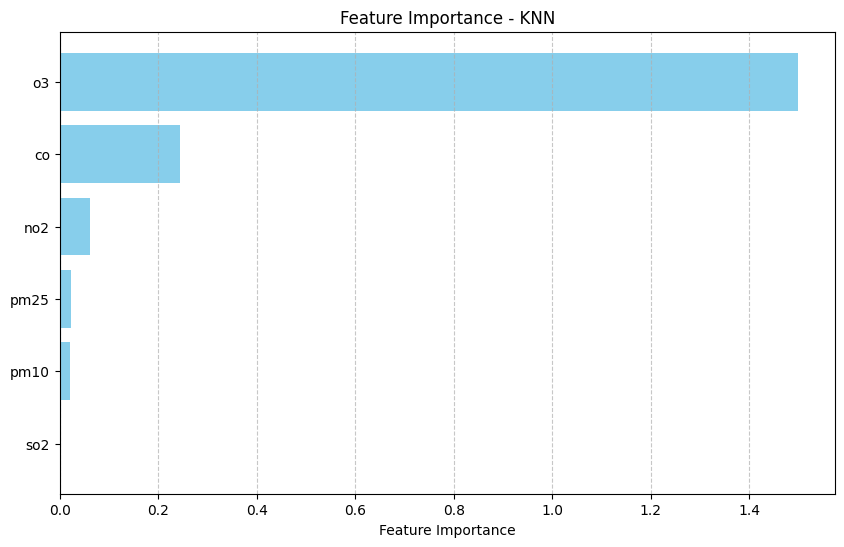

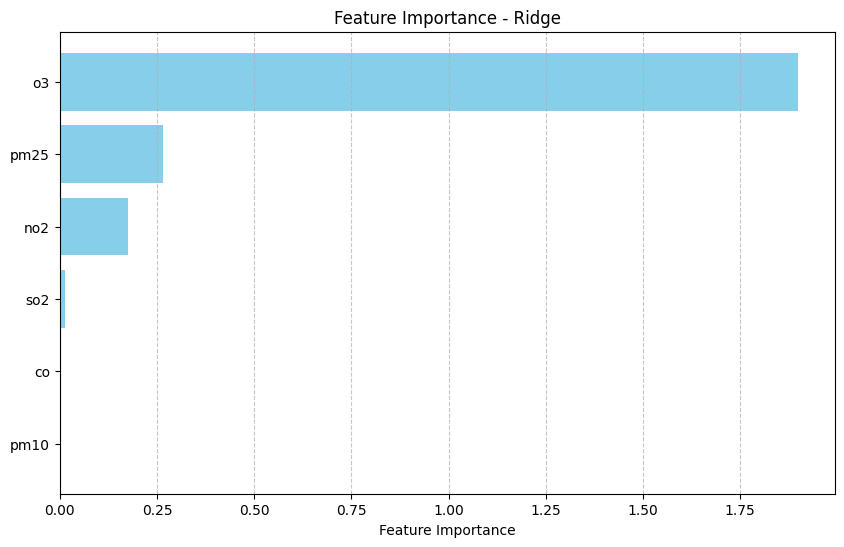

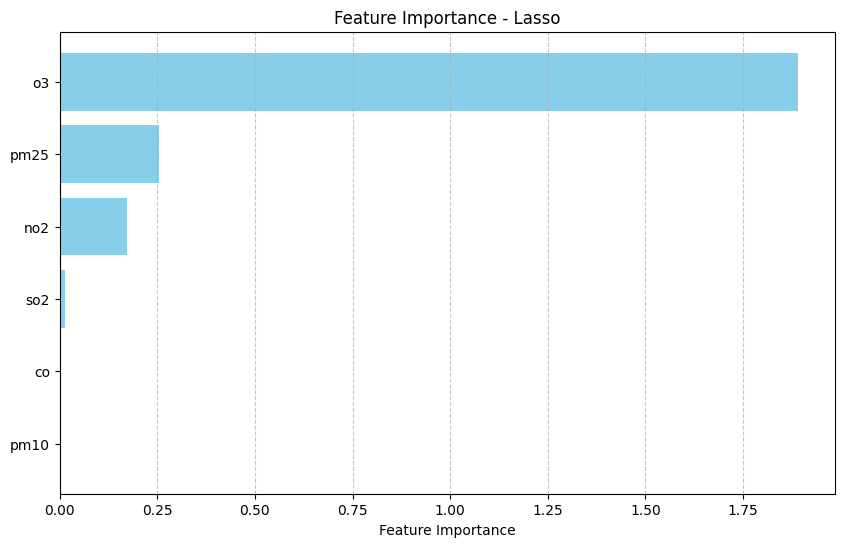

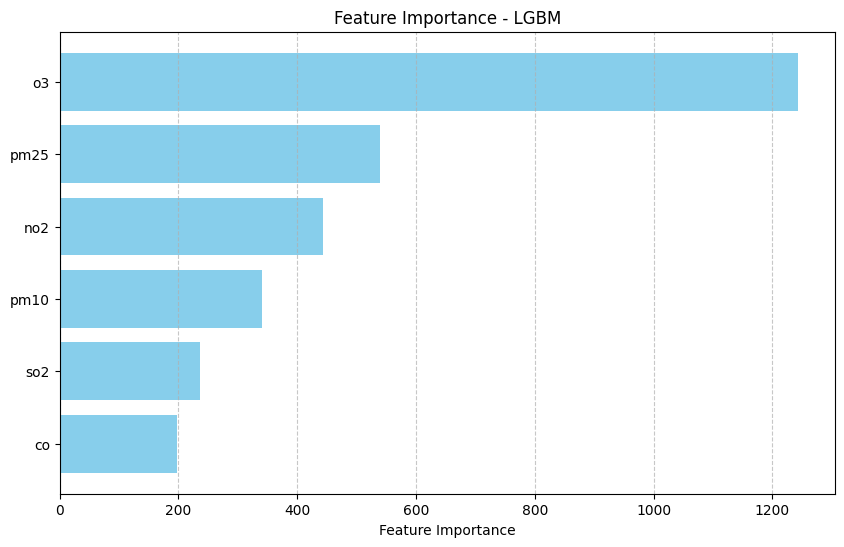

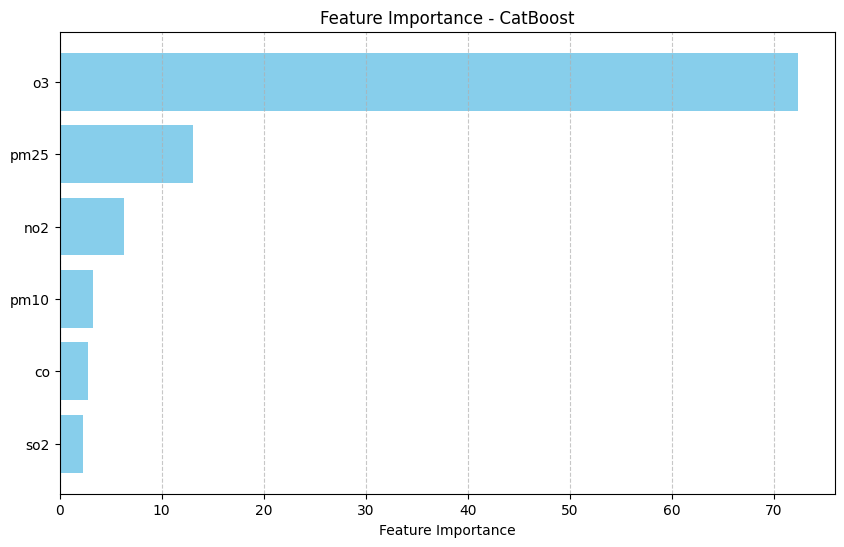

In [ ]:
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]

for name, model in models.items():
    if hasattr(model, "feature_importances_"):  # for tree-based models
        importances = model.feature_importances_
    else:  # the rest - use permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
        importances = perm_importance.importances_mean

    sorted_idx = numpy.argsort(importances)[::-1]
    sorted_features = [feature_names[i] for i in sorted_idx]
    sorted_importances = importances[sorted_idx]
    
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.title(f"Feature Importance - {name}")
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

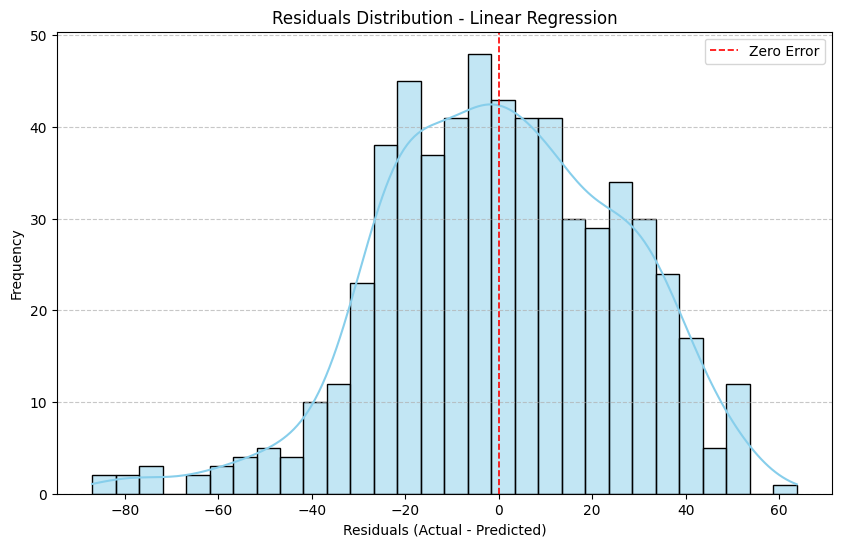

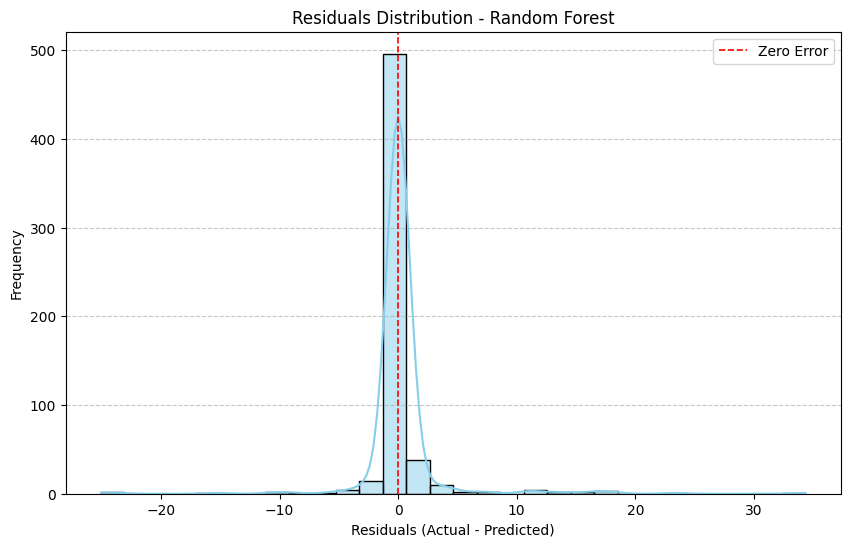

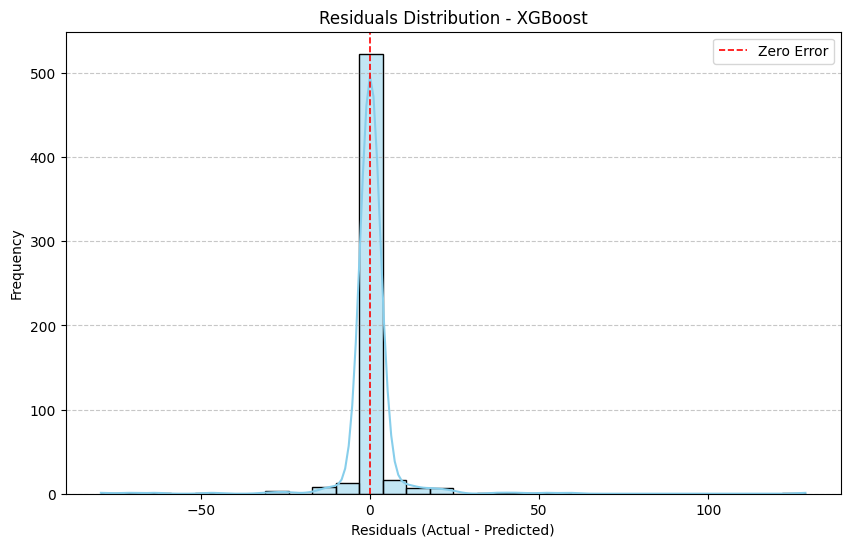

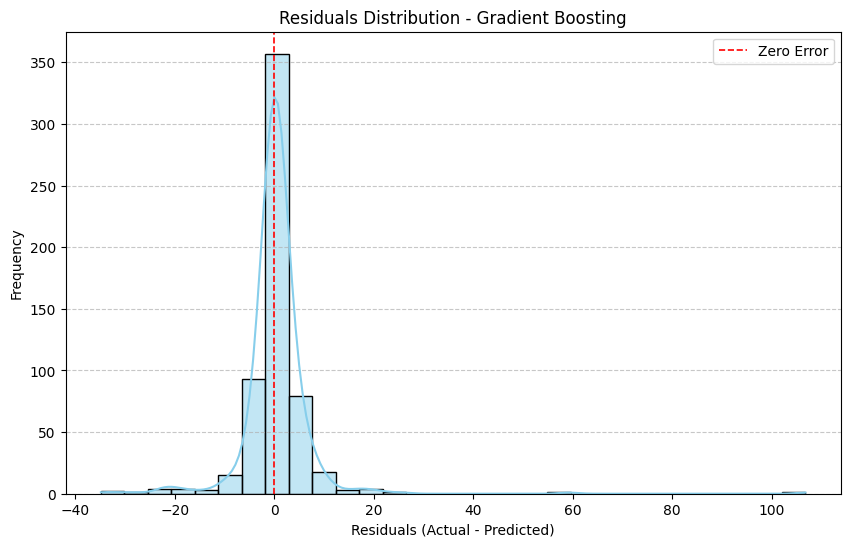

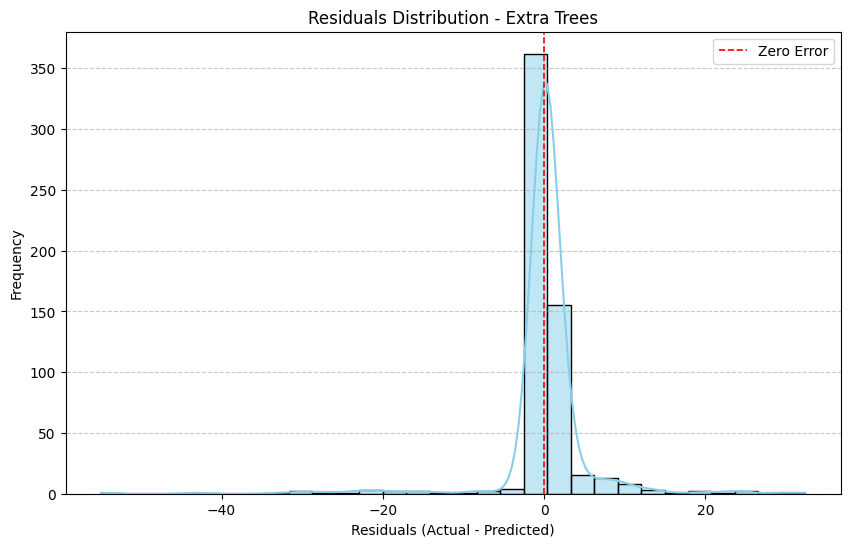

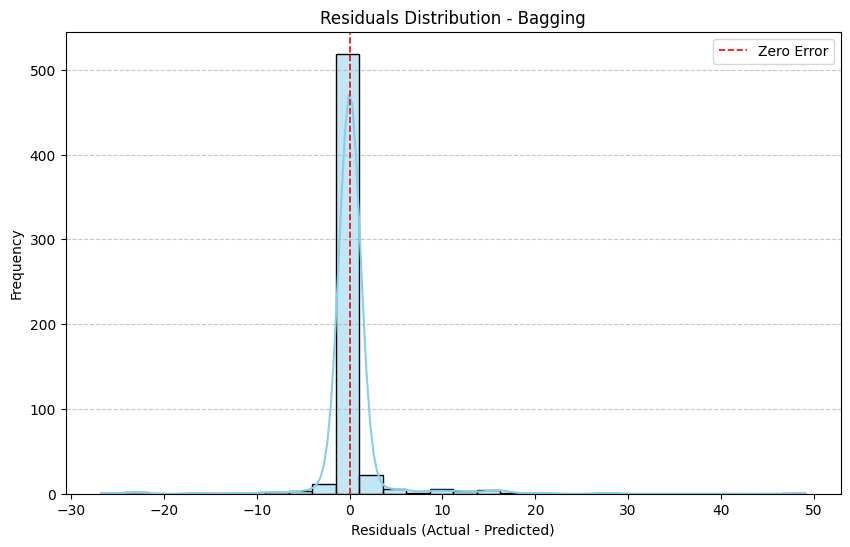

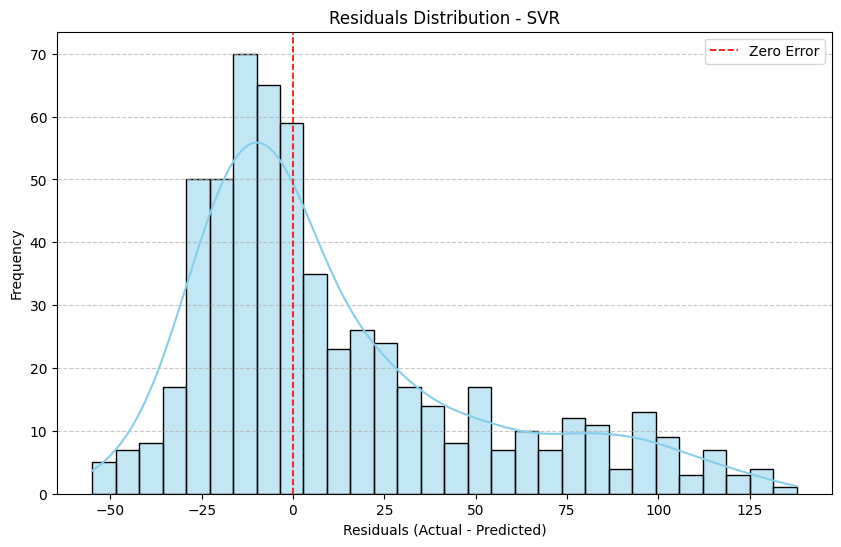

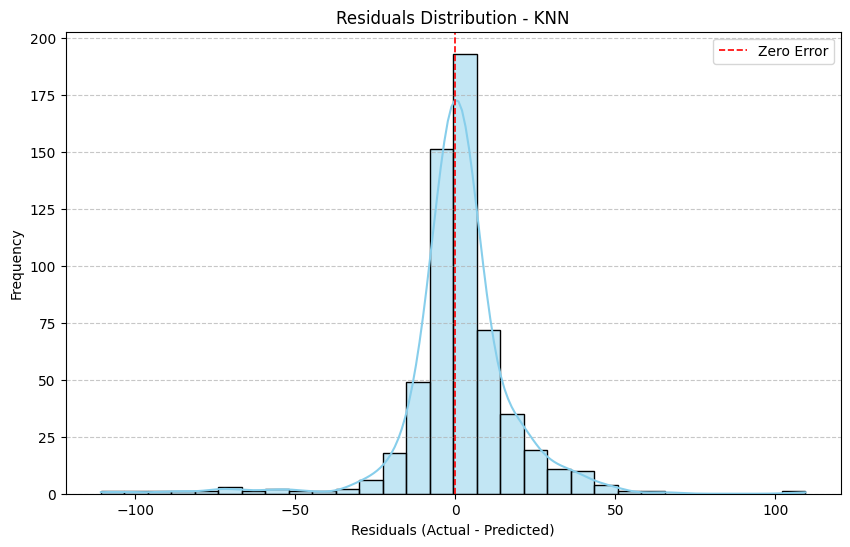

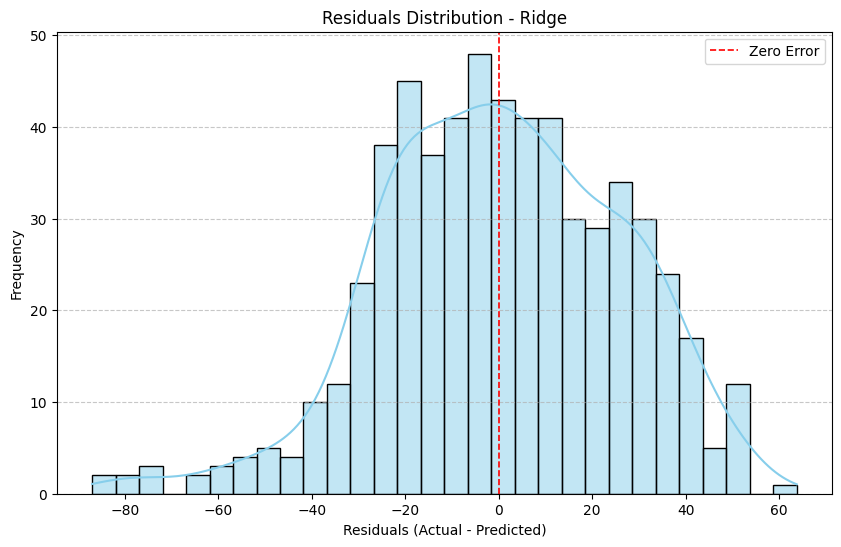

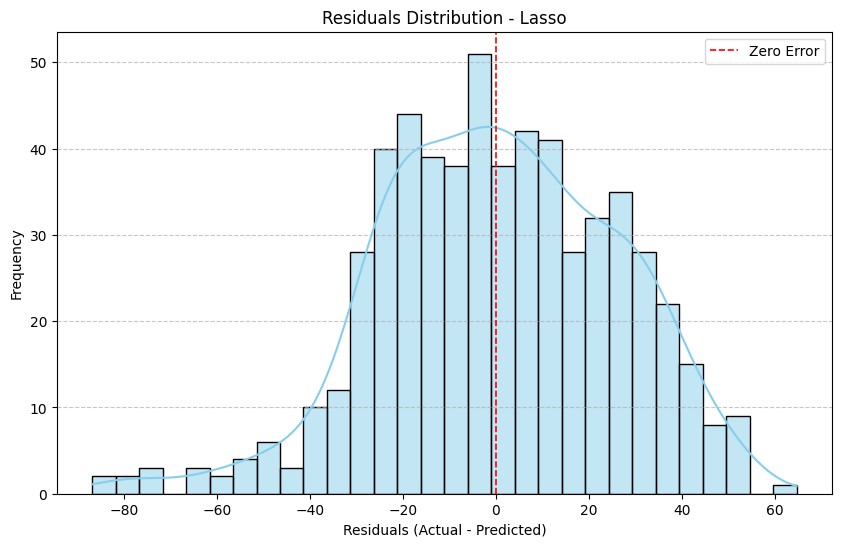

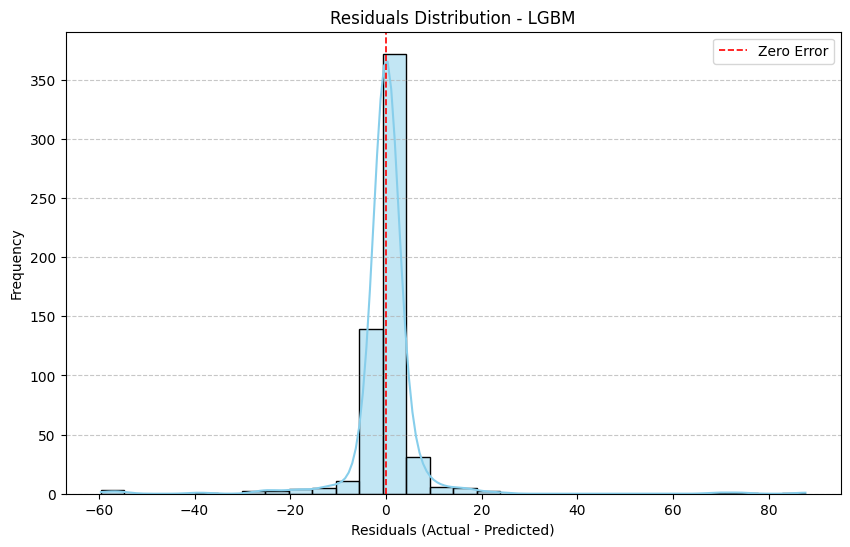

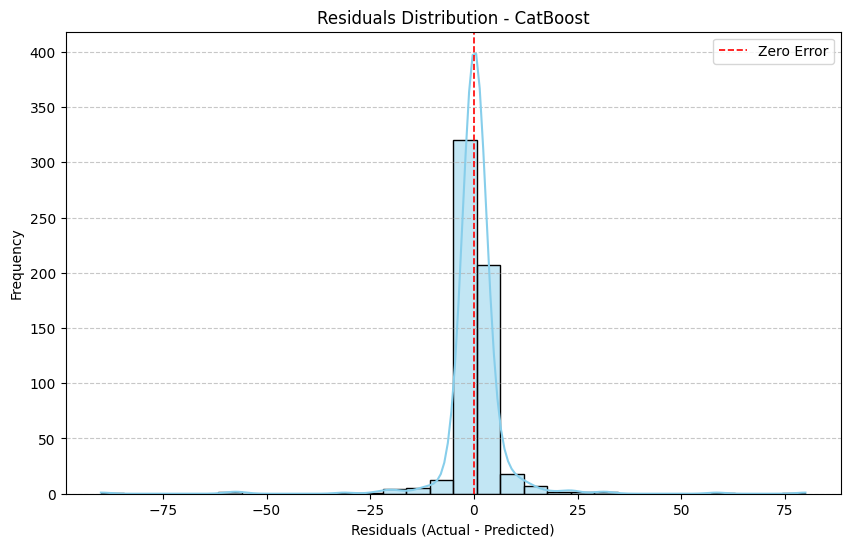

In [ ]:
for name, model in models.items():
    preds = model.predict(X_test)
    residuals = y_test - preds
    
    plt.figure(figsize=(10, 6))
    seaborn.histplot(residuals, kde=True, color="skyblue", bins=30, edgecolor="black")
    plt.title(f"Residuals Distribution - {name}")
    plt.xlabel("Residuals (Actual - Predicted)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axvline(0, color='red', linestyle='--', linewidth=1.2, label="Zero Error")
    plt.legend()
    plt.show()